In [115]:
# 1. Load Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [116]:
# 2. Load your data
df = pd.read_csv('/Users/shokoufehnaseri/Library/CloudStorage/OneDrive-Personal/fourth_semester/UB_presentations_2025/ING-credit_risk/Data/Raw/development_sample.csv')  # <-- Change the path if needed
#df = df[df['target'].notnull()]  # Only keep rows where target is not missing


# target Variable
target	- "Default indicator (1. loan went into default, 0. facility performing, Missing for rejected applications")

In the development dataset, the variable target serves as the default indicator. A value of 0 means the loan was performing (no default), and a value of 1 indicates the loan went into default. However, for applications that were rejected, the target is missing (NaN), as no loan was granted and thus no performance outcome could be observed. Consequently, for the purpose of credit risk modeling, only approved applications (where target is available) are relevant. Using rejected applications would introduce bias, as we cannot know whether these applicants would have defaulted or not. Therefore, we filter the dataset to include only the approved applications with non-missing target values for all supervised modeling and exploratory data analysis (EDA).

In [117]:
# Step 1: Filter to only Approved Applications (target known)
df_filtered = df[df['target'].notnull()].copy()

print(f"Original dataset shape: {df.shape}")
print(f"Filtered dataset shape (only approved loans): {df_filtered.shape}")

# Quick check: target distribution
print(df_filtered['target'].value_counts(normalize=True))


Original dataset shape: (50000, 35)
Filtered dataset shape (only approved loans): (36718, 35)
target
0.0    0.969307
1.0    0.030693
Name: proportion, dtype: float64


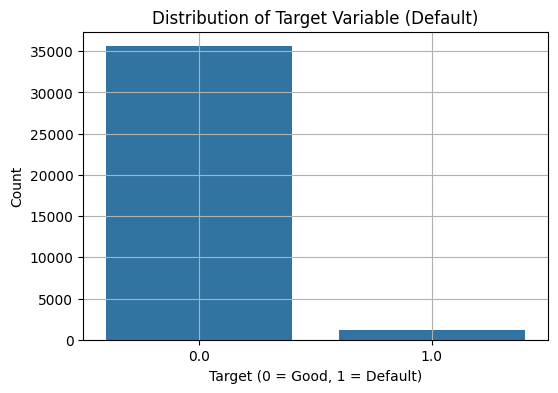

Target Distribution (%):
target
Good (0)       96.93
Default (1)     3.07
Name: proportion, dtype: float64


In [118]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 2: EDA of Target Variable

def eda_target(df_filtered):
    plt.figure(figsize=(6,4))
    sns.countplot(x='target', data=df_filtered)
    plt.title('Distribution of Target Variable (Default)')
    plt.xlabel('Target (0 = Good, 1 = Default)')
    plt.ylabel('Count')
    plt.grid(True)
    plt.show()
    
    # Show percentages
    target_distribution = df_filtered['target'].value_counts(normalize=True).rename({0:'Good (0)', 1:'Default (1)'}).mul(100).round(2)
    print("Target Distribution (%):")
    print(target_distribution)

# Apply EDA
eda_target(df_filtered)


Great follow-up! Unbalanced target classes are very common in credit risk modeling.  
Let me explain **clearly** what to do and how.

---

# ⚠️ Problem:
Your `target` variable is **imbalanced** — typically:

- 90–95% = good loans (`0`)
- 5–10% = defaults (`1`)

This means:
- **A simple model predicting all 0s** could get 90–95% accuracy.
- But it would be **useless** for identifying risk (defaults).

---

# 🧠 Why this matters:

| Issue | Impact |
|------|--------|
| Model ignores minority class | Poor recall for defaulters (target = 1) |
| Accuracy becomes misleading | Looks high, but you're missing actual risk |
| Credit decisions become biased | Could approve risky clients unknowingly |

---

# ✅ Solutions (Best Practices)

### ✔️ 1. **Use the Right Evaluation Metric**
Instead of accuracy, focus on:
- **F1-score**
- **ROC AUC**
- **Precision/Recall**
- **Confusion Matrix**

```python
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))
```

---

### ✔️ 2. **Try Class Weighting**
Let the model learn to **focus more on defaulters**.

✅ Example in Logistic Regression or Random Forest:
```python
model = LogisticRegression(class_weight='balanced')
```

✅ Example in XGBoost:
```python
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
```

✅ Example in `Trainer` from HuggingFace:
```python
loss_fct = torch.nn.CrossEntropyLoss(weight=torch.tensor([0.2, 0.8]).to(device))
```

---

### ✔️ 3. **Use Resampling (if needed)**

| Method | When to use |
|--------|-------------|
| **Oversampling (SMOTE, Random)** | If model ignores positives completely |
| **Undersampling** | If dataset is large |
| **Hybrid (e.g. SMOTEENN)** | Advanced modeling

✅ Example (Random Oversampling):
```python
from sklearn.utils import resample

minority = df[df['target'] == 1]
majority = df[df['target'] == 0]

minority_upsampled = resample(minority, replace=True, n_samples=len(majority), random_state=42)
df_balanced = pd.concat([majority, minority_upsampled])
```

---

### ✔️ 4. **Use Tree-Based Models**
Ensemble models like:
- **XGBoost**
- **LightGBM**
- **CatBoost**

...handle imbalance better than naive logistic regression.

---

### ✔️ 5. **Threshold Tuning**
After predicting probabilities, choose a **custom threshold** (not just 0.5) to improve recall on defaulters.

---

# 🎯 What I recommend for your case:

| Step | Action |
|------|--------|
| ✅ | Use `class_weight='balanced'` in classical models |
| ✅ | Use `F1-score` and `AUC` to evaluate |
| ✅ | Try **upsampling** defaulted class if you do logistic regression |
| ✅ | Consider `scale_pos_weight` in XGBoost |
| ✅ | Use **confusion matrix** to see real risk performance |

---

Would you like me to generate:
- A balanced logistic regression training example?
- Or help you implement `scale_pos_weight` in XGBoost?

Just say what you're modeling with — and I’ll give you tailored code! 💡

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, pointbiserialr
from pandas.api.types import is_numeric_dtype

def analyze_categorical_relationship(df, cat_col, target_col):
    df_clean = df[[cat_col, target_col]].dropna()
    contingency = pd.crosstab(df_clean[cat_col], df_clean[target_col])
    chi2, p, dof, expected = chi2_contingency(contingency)
    n = contingency.sum().sum()
    phi2 = chi2 / n
    r, k = contingency.shape
    cramers_v = np.sqrt(phi2 / min(k - 1, r - 1))
    corr = pointbiserialr(df_clean[cat_col], df_clean[target_col])[0] if is_numeric_dtype(df_clean[cat_col]) else None

    result = {
        'categorical_variable': cat_col,
        'chi2_statistic': chi2,
        'p_value': p,
        'cramers_v': cramers_v,
        'point_biserial_corr (if numeric)': corr
    }
    return result

def categorical_eda_pipeline(df, var, target='target'):
    print(f"--- EDA for {var} ---")
    
    # Check for missing values
    na_count = df[var].isnull().sum()
    print(f"Missing values in {var}: {na_count}")
    
    if na_count > 0:
        print(f"⚠️ Skipping analysis for {var} due to missing values.")
        return
    
    # Frequency table
    print("\nValue counts:")
    display(df[var].value_counts())

    # Count plot
    plt.figure(figsize=(8, 4))
    sns.countplot(x=var, data=df, order=df[var].value_counts().index)
    plt.title(f"Distribution of {var}")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

    # Stacked bar plot of target by category
    ct = pd.crosstab(df[var], df[target], normalize='index')
    ct.plot(kind='bar', stacked=True, figsize=(8, 4), colormap='viridis')
    plt.title(f'Target Distribution by {var}')
    plt.ylabel('Proportion')
    plt.xlabel(var)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

    # Statistical test
    stats = analyze_categorical_relationship(df, var, target)
    print("\nStatistical Relationship:")
    for k, v in stats.items():
        print(f"{k}: {v}")


In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr

def numeric_eda_pipeline(df, var, target='target'):
    print(f"--- EDA for {var} ---")
    
    # Check for missing values
    na_count = df[var].isnull().sum()
    print(f"Missing values in {var}: {na_count}")
    
    if na_count > 0:
        print(f"⚠️ Skipping analysis for {var} due to missing values.")
        return

    # Summary statistics by target
    print("\nDescriptive statistics by target:")
    display(df.groupby(target)[var].describe())

    # Histogram
    plt.figure(figsize=(8, 4))
    sns.histplot(df[var], bins=30, kde=True)
    plt.title(f"Distribution of {var}")
    plt.xlabel(var)
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    # Boxplot by target
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=target, y=var, data=df)
    plt.title(f"{var} by Credit Risk (Target)")
    plt.grid(True)
    plt.show()

    # Density plot by target
    plt.figure(figsize=(10, 5))
    sns.kdeplot(data=df[df[target] == 0], x=var, label='Target=0', fill=True)
    sns.kdeplot(data=df[df[target] == 1], x=var, label='Target=1', fill=True)
    plt.title(f"Distribution of {var} by Target")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Point-biserial correlation
    corr, p = pointbiserialr(df[var], df[target])
    print(f"\nPoint-biserial correlation: {corr:.6f}, p-value: {p:.6f}")

# Dropping Non-Predictive Identifier and Timestamp Columns
We drop 'ID', 'customer_id', and 'application_date' because they do not provide predictive value for default risk. 'ID' and 'customer_id' are unique identifiers with no statistical relevance, and 'application_date' may introduce time-related bias or noise unless specifically engineered for features like seasonality or application trends.

In [121]:
df_filtered = df_filtered.drop(columns=['ID', 'customer_id', 'application_date' ])

# application_status 
- Application status (Approved/Rejected)
Since we are focusing only on approved applications (where the target variable is available), we can safely remove the application_status column, as its information has already been accounted for during the data filtering process.

In [122]:
# Drop the 'application_status' column since its information is redundant
df_filtered = df_filtered.drop(columns=['Application_status'])

In [123]:
df_filtered.head()

,target,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,...,Var21,Var22,Var23,Var24,Var25,Var26,Var27,Var28,Var29,Var30
0,0.0,1,2.0,1,7800,99,1,108.73,NaN,5640,...,1,1,1,0,6768.42,0.00,0,0,0,3899
1,0.0,1,1.0,2,11100,78,1,195.99,11200.0,3000,...,0,0,0,15000,5937.66,3870.60,0,0,0,3899
2,0.0,2,3.0,1,2400,15,1,248.34,NaN,6240,...,2,2,2,0,5647.77,1463.08,0,0,10,3899
3,0.0,3,1.0,2,11800,30,6,3538.68,12400.0,4560,...,0,0,0,0,3594.90,21563.78,0,0,10,3899
5,0.0,1,2.0,1,7200,36,1,267.19,NaN,3960,...,1,2,2,0,1828.62,NaN,0,0,10,3899


# Var1 - Number of applicants

In [124]:
# Create new transformed variable
df_filtered['Var1_transformed'] = df_filtered['Var1'].apply(lambda x: 'Single Applicant' if x == 1 else 'Multiple Applicants')

# Check
print(df_filtered['Var1_transformed'].value_counts())


Var1_transformed
Single Applicant       28043
Multiple Applicants     8675
Name: count, dtype: int64


In [125]:
df_filtered['Var1_binary'] = df_filtered['Var1'].apply(lambda x: 0 if x == 1 else 1)


--- EDA for Var1_transformed ---
Missing values in Var1_transformed: 0

Value counts:


Var1_transformed
Single Applicant       28043
Multiple Applicants     8675
Name: count, dtype: int64

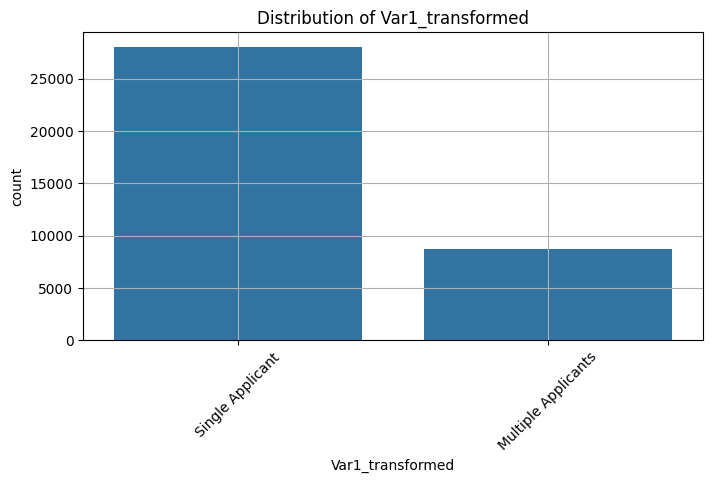

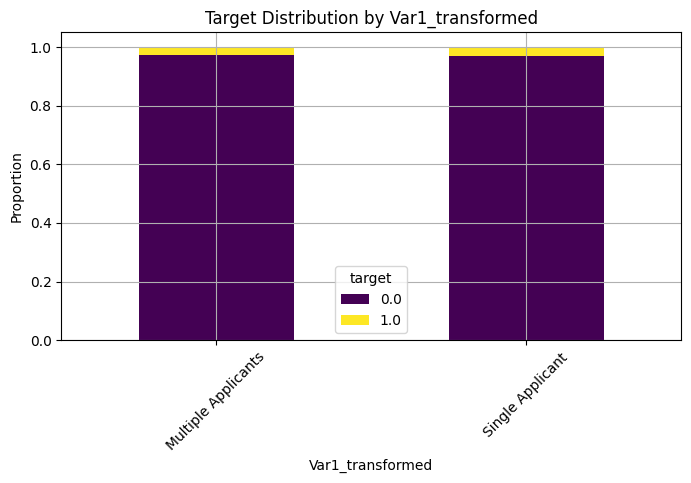


Statistical Relationship:
categorical_variable: Var1_transformed
chi2_statistic: 3.634288786212183
p_value: 0.05660078284433225
cramers_v: 0.009948788727312433
point_biserial_corr (if numeric): None


In [126]:
categorical_eda_pipeline(df_filtered, 'Var1_transformed')

# Var2 - Loan purpose

Var2	[1]	- Car Loan

Var2	[2]	- House Renovation

Var2	[3]	- Short Cash

In [127]:
categorical_eda_pipeline(df_filtered, 'Var2')

--- EDA for Var2 ---
Missing values in Var2: 1018
⚠️ Skipping analysis for Var2 due to missing values.


In [128]:
df_filtered['Var2'] = df_filtered['Var2'].fillna(0).astype(int)
loan_purpose_map = {
    0: 'Unknown',
    1: 'Car Loan',
    2: 'House Renovation',
    3: 'Short Cash'
}
df_filtered['LoanPurpose'] = df_filtered['Var2'].map(loan_purpose_map)


In [129]:
df_filtered['Var2'].head()

0    2
1    1
2    3
3    1
5    2
Name: Var2, dtype: int64

In [130]:
df_filtered['LoanPurpose']

0        House Renovation
1                Car Loan
2              Short Cash
3                Car Loan
5        House Renovation
               ...       
49992          Short Cash
49993    House Renovation
49995            Car Loan
49997            Car Loan
49999          Short Cash
Name: LoanPurpose, Length: 36718, dtype: object

--- EDA for LoanPurpose ---
Missing values in LoanPurpose: 0

Value counts:


LoanPurpose
Car Loan            15744
Short Cash          10641
House Renovation     9315
Unknown              1018
Name: count, dtype: int64

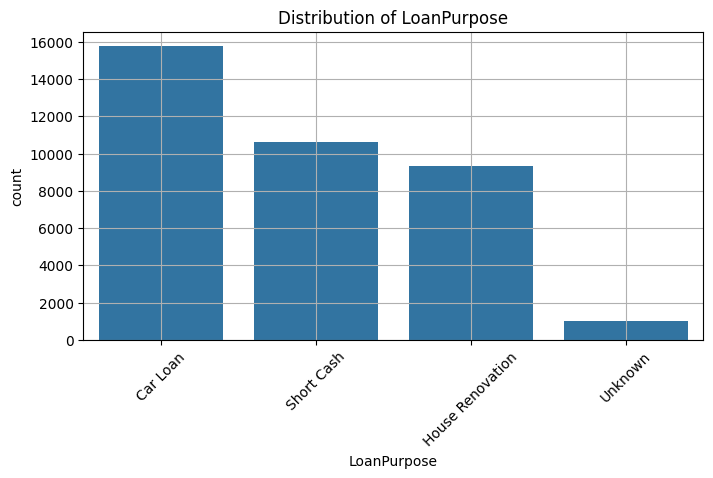

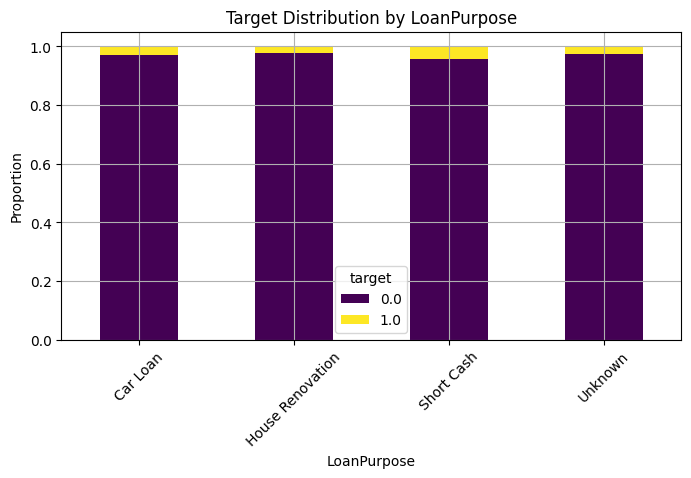


Statistical Relationship:
categorical_variable: LoanPurpose
chi2_statistic: 62.26966399920172
p_value: 1.924005354907386e-13
cramers_v: 0.041181176750653886
point_biserial_corr (if numeric): None


In [131]:
# 6. Example: Analyze Var2
categorical_eda_pipeline(df_filtered,'LoanPurpose')

Var2 represents the purpose for which a loan was taken. It includes four categories: Car Loan, House Renovation, Short Cash, and Unknown (for missing values). Most applicants requested a loan for purchasing a car, followed by Short Cash and House Renovation. The Unknown category accounts for a smaller portion of the data.

When looking at default rates across loan purposes, all categories show generally low default rates. However, loans for Short Cash and Unknown purposes show a slightly higher tendency to default, which may suggest increased credit risk associated with these groups.

Statistical testing confirms that the relationship between loan purpose and default is significant, with a chi-squared value of 62.27 and a p-value close to zero. However, the strength of this relationship is weak, as indicated by the low Cramér’s V value of 0.041 and point-biserial correlation of 0.031. This means that although loan purpose is statistically linked to default behavior, its impact is relatively small on its own.

In summary, Var2 (Loan Purpose) is a useful feature for modeling, especially when combined with other variables. Including an “Unknown” category instead of removing missing values helps retain potentially valuable risk information. While not a strong standalone predictor, this variable adds helpful context in a credit risk model.

# Distribution Channel (Var3)

Var3 indicates the channel through which a loan application was submitted and includes three main categories: Direct, Broker, and Online, originally encoded as 1, 2, and 3. During data inspection, it was found that some values also appeared as string labels (e.g., 'Direct', 'Online'), likely due to inconsistent encoding or partial mapping. This issue was resolved by standardizing all values to ensure consistency before analysis.

To ensure consistency and avoid duplicated categories, all values were mapped to unified string labels. This step was essential before applying one-hot or label encoding for modeling. Understanding the distribution of application channels may reveal patterns related to customer acquisition strategies or risk profiles.



In [132]:
missing_var2 = df_filtered['Var3'].isnull().sum()
print(missing_var2)  # 

1018


In [133]:
# Calculate mode of Var3
mode_var3 = df_filtered['Var3'].mode()[0]

# Fill missing values with the mode
df_filtered['Var3'] = df_filtered['Var3'].fillna(mode_var3)

# Optional: Check if missing values are handled
print(df_filtered['Var3'].isnull().sum())


0


In [134]:
df_filtered['Var3'].value_counts()

Var3
1         19124
2         12066
3          5251
Direct      248
Online       29
Name: count, dtype: int64

In [135]:
# Step 1: Convert all values to string
df_filtered['Var3'] = df_filtered['Var3'].astype(str)

# Step 2: Define the mapping (string to numeric)
var3_map_str = {
    '1': 1,
    '2': 2,
    '3': 3,
    'Direct': 1,
    'Broker': 2,
    'Online': 3
}

# Step 3: Map and convert to integer
df_filtered['Var3'] = df_filtered['Var3'].map(var3_map_str).astype('Int64')


In [136]:
print(df_filtered['Var3'].value_counts())


Var3
1    19372
2    12066
3     5280
Name: count, dtype: Int64


In [137]:
# Step 1: Define a complete mapping from both numbers and strings to unified labels
channel_map = {
    1: 'Direct',
    2: 'Broker',
    3: 'Online',
    'Direct': 'Direct',
    'Online': 'Online'
}

# Step 2: Apply the mapping to create a new cleaned column
df_filtered['DistributionChannel'] = df_filtered['Var3'].map(channel_map)

--- EDA for DistributionChannel ---
Missing values in DistributionChannel: 0

Value counts:


DistributionChannel
Direct    19372
Broker    12066
Online     5280
Name: count, dtype: int64

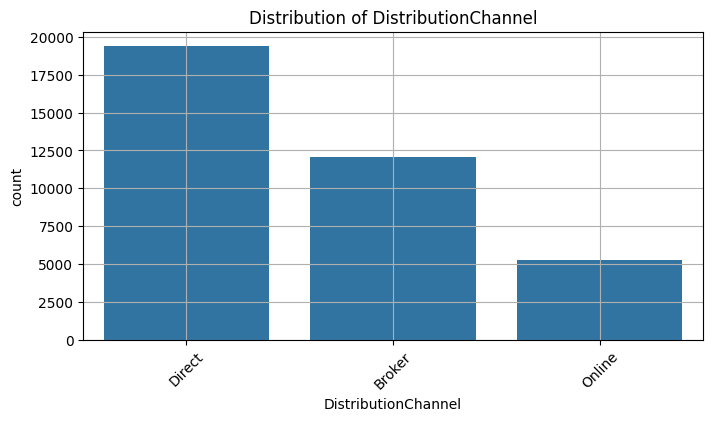

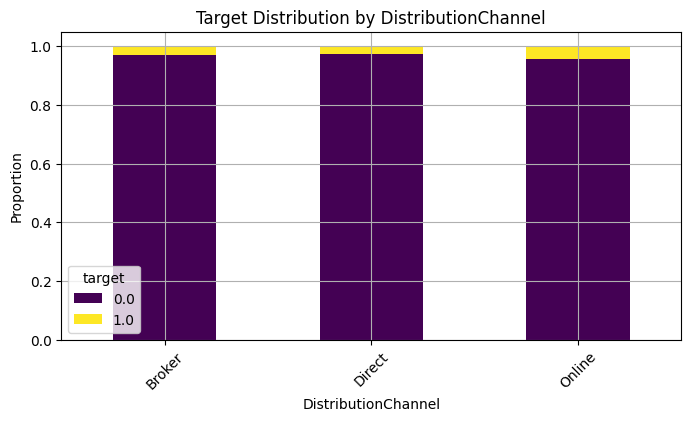


Statistical Relationship:
categorical_variable: DistributionChannel
chi2_statistic: 27.32763190747986
p_value: 1.163804761096815e-06
cramers_v: 0.02728107571363797
point_biserial_corr (if numeric): None


In [138]:
categorical_eda_pipeline(df_filtered, 'DistributionChannel')



The variable Var3 represents the distribution channel through which the loan application was submitted: 1 for Direct, 2 for Broker, and 3 for Online. Most loans were submitted through the Direct channel (around 18,000), followed by Broker and Online.

Default rates appear relatively similar across all channels. However, a chi-squared test indicates a statistically significant relationship between Var3 and the target variable (p-value < 0.00001). Despite this, the strength of the association is very weak, with a Cramér’s V of 0.027 and a point-biserial correlation of 0.025.

In summary, although the distribution channel shows a statistically significant association with loan default, its practical impact is limited. It may still provide value when used alongside other variables in a predictive model.

# Var4 - Application amount

In [139]:
print(df_filtered['Var4'].value_counts())


Var4
4000     217
10900    207
4500     206
10600    206
4100     206
        ... 
57600      1
57200      1
59500      1
61800      1
58700      1
Name: count, Length: 460, dtype: int64


--- EDA for Var4 ---
Missing values in Var4: 0

Descriptive statistics by target:


,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0.0,35591.0,17790.688657,12219.55576,700.0,7800.0,14900.0,25700.0,63700.0
1.0,1127.0,15776.131322,11995.05404,1700.0,6000.0,12600.0,22550.0,59600.0


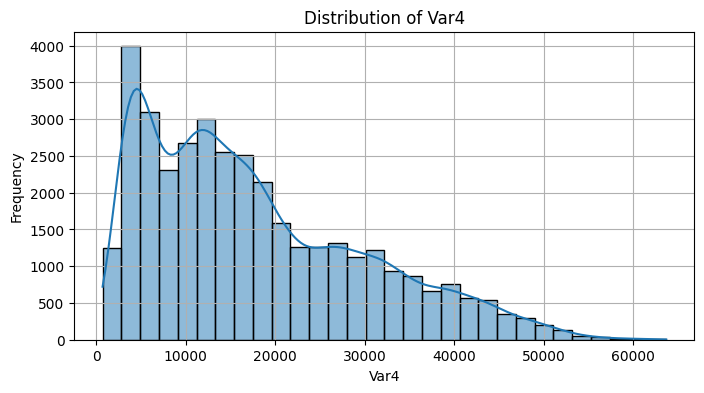

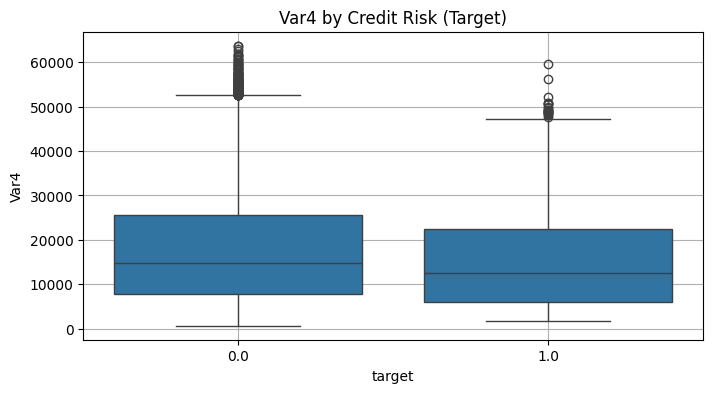

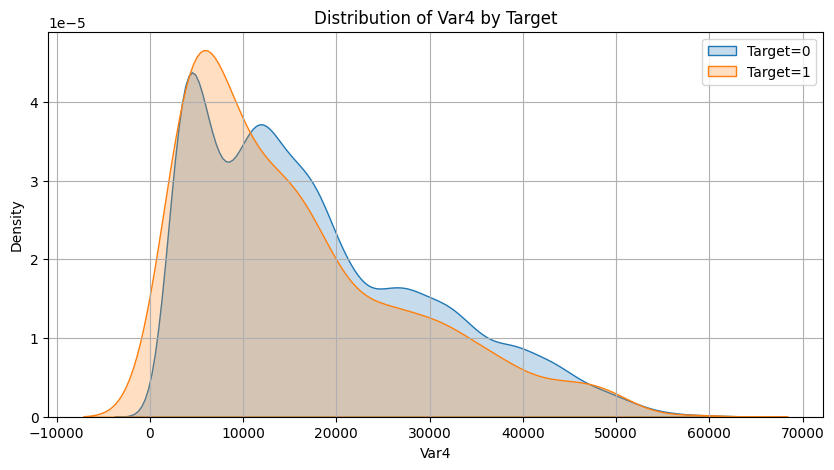


Point-biserial correlation: -0.028442, p-value: 0.000000


In [140]:
numeric_eda_pipeline(df_filtered, 'Var4')

Var4 represents the loan amount requested by applicants and is a continuous numerical variable with 460 unique values. The distribution is strongly right-skewed, with most loan applications concentrated below 30,000 and a long tail extending beyond 60,000. The most common loan amounts range between 4,000 and 20,000, while larger amounts above 50,000 are rare and typically occur only once, indicating a clear concentration of typical loan sizes.

When comparing credit outcomes, applicants who defaulted (target = 1) tend to request slightly lower amounts on average (mean ≈ 15,800) than those who did not default (mean ≈ 17,800). The density plot reveals a subtle leftward shift in the distribution for defaulters, suggesting smaller loans are marginally more common in this group. Boxplots show a similar pattern, with slightly lower medians and interquartile ranges for defaulted loans, though there is considerable overlap between the two groups.


The point-biserial correlation between Var4 and the binary target is -0.028, with a highly significant p-value (< 0.0000001). This indicates a very weak negative correlation, meaning that applicants requesting slightly lower loan amounts are marginally more likely to default.

Despite the statistical significance (likely due to the large sample size), the effect size is negligible, suggesting that application amount has limited predictive power on its own and should be interpreted in combination with other variables in the model.

# Var5 - Credit duration (months)

In [141]:
df_filtered['Var5'].isnull().sum()


np.int64(0)

In [142]:
df_filtered['Var5'].values


array([ 99,  78,  15, ..., 111,  18,   9], shape=(36718,))

--- EDA for Var5 ---
Missing values in Var5: 0

Descriptive statistics by target:


,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0.0,35591.0,33.437892,31.285232,6.0,15.0,27.0,39.0,312.0
1.0,1127.0,30.915705,33.414361,6.0,12.0,24.0,36.0,309.0


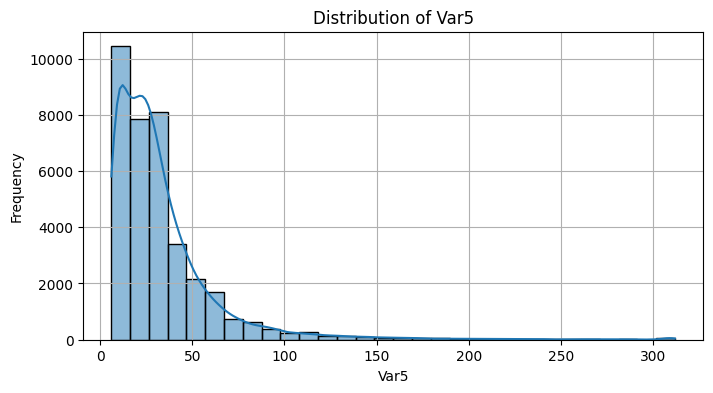

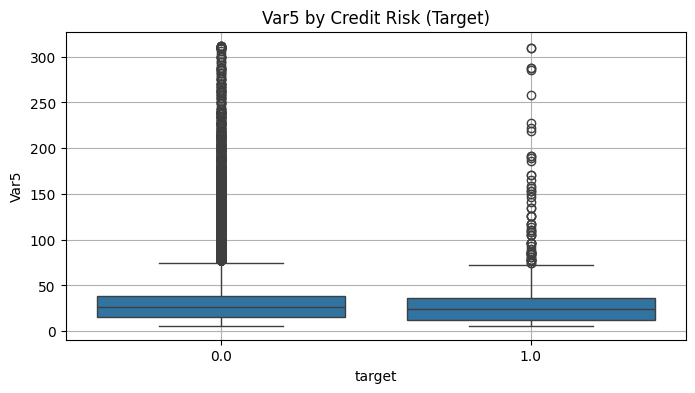

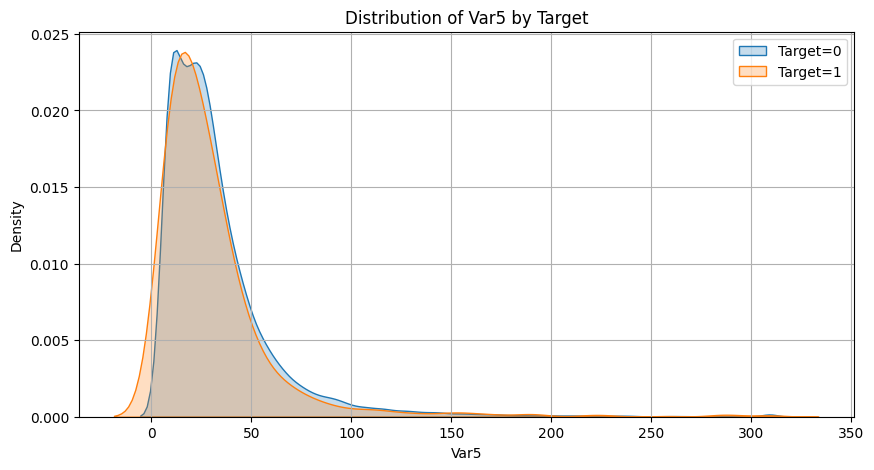


Point-biserial correlation: -0.013875, p-value: 0.007844


In [143]:
numeric_eda_pipeline(df_filtered, 'Var5')

Var5 is a continuous numeric variable with no missing values. Its distribution is heavily right-skewed, with the majority of values clustered between 10 and 50, and a long tail reaching beyond 300. The variable shows a wide range, with some outliers in higher values.

When comparing Var5 across credit outcomes:

Non-defaulters (target = 0) have a slightly higher mean (≈ 33.4) compared to defaulters (≈ 30.9).

Median and interquartile ranges are also slightly higher for non-defaulters.

Boxplots reveal a similar spread for both groups, with overlapping distributions and many outliers in both.

The point-biserial correlation between Var5 and the target variable is –0.014, with a statistically significant p-value. This indicates a very weak negative correlation, suggesting that lower Var5 values are slightly more common among defaulters, though the difference is minimal.

Conclusion: While Var5 shows a statistically significant relationship with default risk, the effect is weak. It may contribute more meaningfully when combined with other predictors in a multivariate credit risk model.

# Var6 - Payment frequency
Var6 represents the loan repayment frequency, with values: 1 for monthly, 3 for quarterly, and 6 for bi-yearly payments. This categorical variable indicates how often a borrower is expected to make loan payments

--- EDA for Var6 ---
Missing values in Var6: 0

Value counts:


Var6
1    29388
3     5511
6     1819
Name: count, dtype: int64

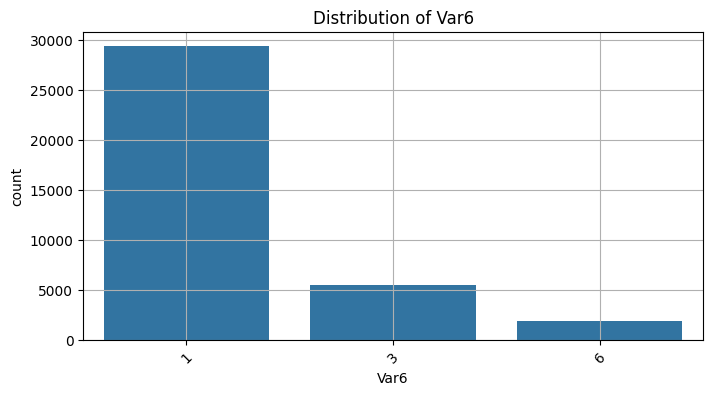

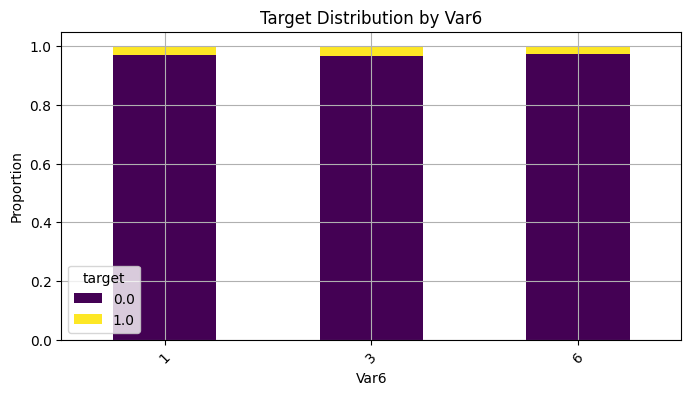


Statistical Relationship:
categorical_variable: Var6
chi2_statistic: 3.3593883103320796
p_value: 0.18643098627486487
cramers_v: 0.00956512378177773
point_biserial_corr (if numeric): -0.002222350108888032


In [144]:
categorical_eda_pipeline(df_filtered, 'Var6')


Var6 represents how often a borrower is expected to make payments: 1 for monthly, 3 for quarterly, and 6 for bi-yearly. The distribution is clearly imbalanced, with the majority of applicants (≈29,000) selecting monthly payments, followed by quarterly (≈5,500), and bi-yearly (≈1,800).

The target distribution (default rate) appears very similar across all payment frequencies. This is supported by the chi-squared test, which shows no statistically significant relationship between Var6 and default (p-value ≈ 0.19). Both the Cramér’s V (0.0096) and the point-biserial correlation (–0.0022) confirm a very weak and negligible association.

Conclusion: While payment frequency provides useful descriptive information, it shows no meaningful relationship with default risk in this dataset. It may still be retained for modeling if used with other features, but its standalone predictive value is limited.

# Var7 - Installment amount

--- EDA for Var7 ---
Missing values in Var7: 0

Descriptive statistics by target:


,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0.0,35591.0,1542.750928,1772.324636,53.98,598.225,1006.31,1758.96,27075.54
1.0,1127.0,1465.485546,1579.675943,92.53,579.625,980.00,1702.92,14435.34


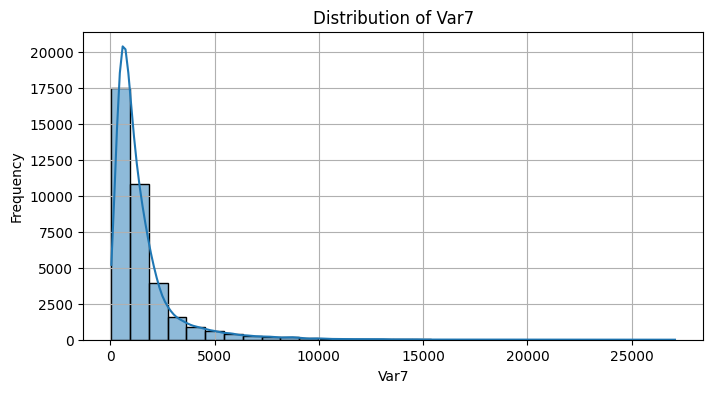

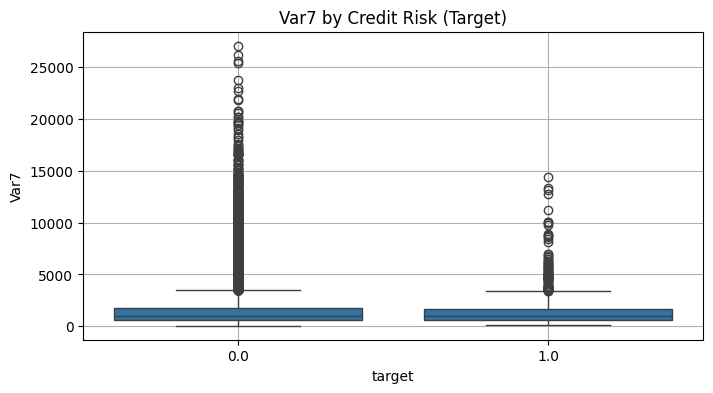

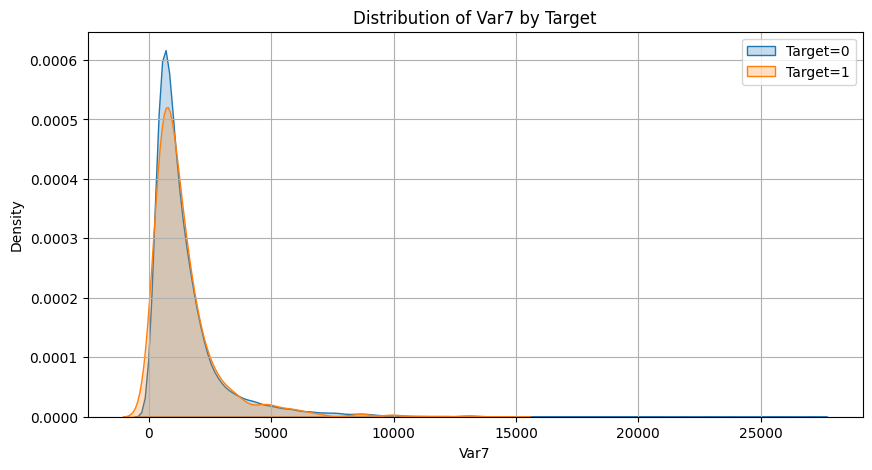


Point-biserial correlation: -0.007543, p-value: 0.148336


In [145]:
numeric_eda_pipeline(df_filtered, 'Var7')


Var7 is a continuous numerical variable with a highly right-skewed distribution. Most values fall below 3,000, with a long tail extending beyond 25,000. The median values for both groups (defaulters and non-defaulters) are below 1,000, with visible outliers present in both.

When comparing credit outcomes:

Non-defaulters (target = 0) have a slightly higher mean (≈ 1,543) than defaulters (≈ 1,465).

The distributions for both groups are similar in shape and scale, as shown in the density and box plots, with only a mild leftward shift for defaulters.

The point-biserial correlation is –0.0075, with a p-value of 0.15, indicating no statistically significant linear relationship between Var7 and default risk.

Conclusion: Var7 does not show a meaningful or statistically significant relationship with the target variable. Although it's informative in describing customer behavior, it is unlikely to be predictive on its own and may only contribute value in interaction with other variables.

# Var8 - Value of the goods (car)

In [146]:
numeric_eda_pipeline(df_filtered, 'Var8')


--- EDA for Var8 ---
Missing values in Var8: 20538
⚠️ Skipping analysis for Var8 due to missing values.


In [147]:
df_filtered.loc[df_filtered['Var2'] != 1, 'Var8'] = 0


In [148]:
df_filtered['Var8'].isnull().sum()


np.int64(0)

--- EDA for Var8 ---
Missing values in Var8: 0

Descriptive statistics by target:


,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0.0,35591.0,15460.259616,21396.312224,0.0,0.0,0.0,27600.0,132100.0
1.0,1127.0,12630.878438,18482.863876,0.0,0.0,0.0,22850.0,80400.0


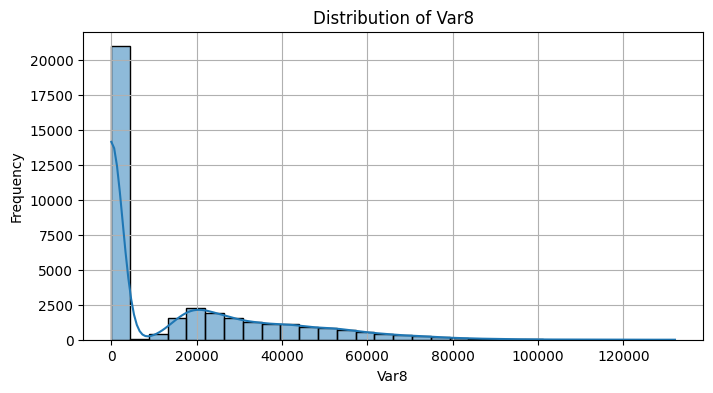

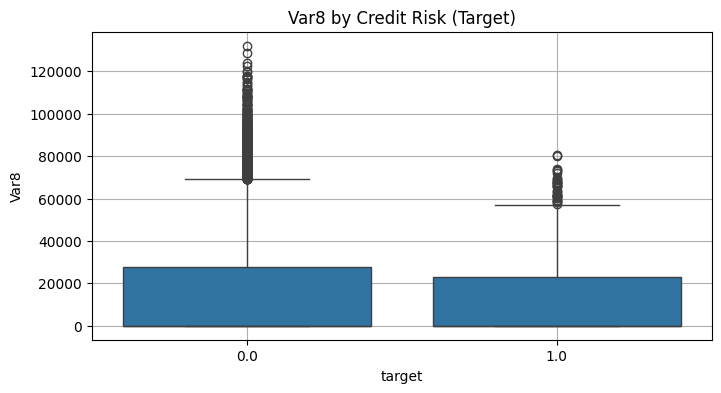

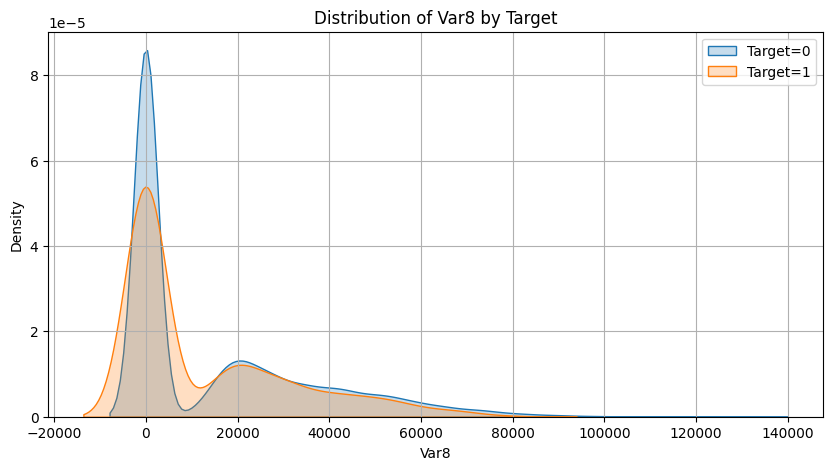


Point-biserial correlation: -0.022893, p-value: 0.000011


In [149]:
numeric_eda_pipeline(df_filtered, 'Var8')

Var8 represents the value of the goods (likely a car) associated with the loan. The variable is continuous and highly right-skewed. A large proportion of values are exactly zero, which is expected since not all loans are car-related. For those with non-zero values, the amounts span a wide range — up to over 130,000.

When comparing credit risk:

Non-defaulters (target = 0) have a higher mean value (~15,460) than defaulters (~12,631),

Boxplots and density plots show considerable overlap between the two groups, though defaulters tend to have slightly lower values.

A point-biserial correlation of –0.023 (p-value ≈ 0.00001) suggests a very weak but statistically significant negative relationship: loans with lower car values are marginally more likely to default.

Conclusion:
Var8 has limited standalone predictive power but might carry value when combined with loan purpose (Var2) or application amount. Zero values should be interpreted as loans not associated with car purchases. The distribution suggests treating it with care (e.g., log transformation or outlier handling) during modeling.



# Var9 - Application data: income of main applicant
Var9 represents the reported income of the main loan applicant. It is a continuous numerical variable, typically used to assess repayment ability. Higher income values may indicate lower credit risk, though the predictive power depends on the context and other features like loan amount or employment type.

--- EDA for Var9 ---
Missing values in Var9: 0

Descriptive statistics by target:


,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0.0,35591.0,10080.010115,5245.458589,0.0,6000.0,8880.0,13200.0,43320.0
1.0,1127.0,8808.660160,5832.281472,0.0,5040.0,7920.0,12720.0,33720.0


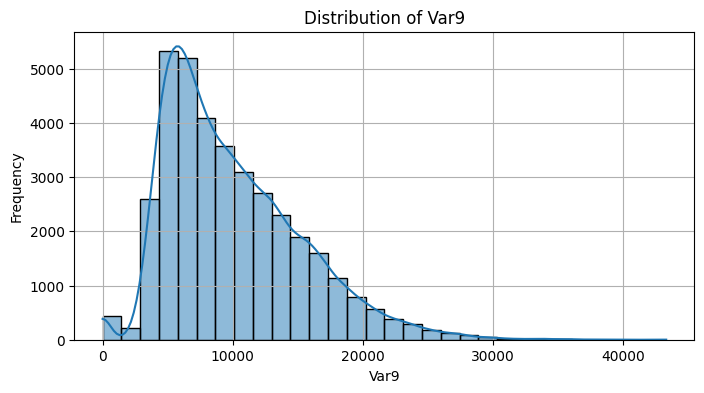

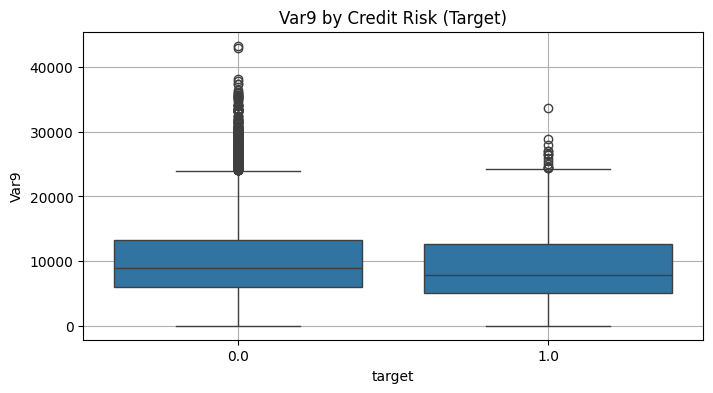

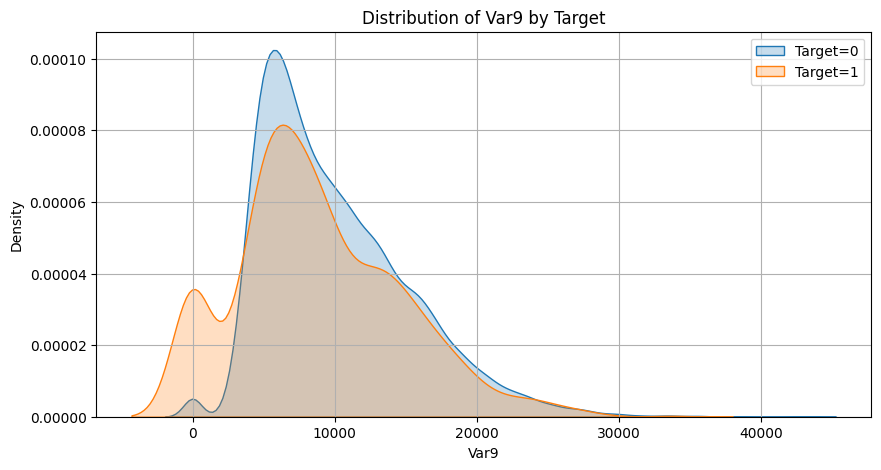


Point-biserial correlation: -0.041620, p-value: 0.000000


In [150]:
numeric_eda_pipeline(df_filtered, 'Var9')

The distribution is right-skewed, with most incomes falling below 20,000 and a long tail extending beyond 40,000. Median income is slightly lower among defaulters (≈ 7,920) compared to non-defaulters (≈ 8,880).

The boxplot and density plot show that while both groups share a similar distribution shape, applicants who defaulted generally report lower income. The point-biserial correlation is –0.042, and statistically significant (p-value ≈ 0.000), indicating a weak but meaningful negative relationship: lower income is slightly associated with higher credit risk.

Conclusion:
Var9 has a weak but statistically significant relationship with default. Although not a strong standalone predictor, income could contribute to credit risk prediction when used alongside other financial and behavioral features.



# Var10 - Application data: income of second applicant
Var10 represents the reported income of a second applicant, if present. This variable is typically zero for single applicants and positive for joint applications. It can be used to assess the total household income, which may improve loan repayment capacity and reduce credit risk.

In [151]:
numeric_eda_pipeline(df_filtered, 'Var10')

--- EDA for Var10 ---
Missing values in Var10: 28043
⚠️ Skipping analysis for Var10 due to missing values.


Var10 represents income of a second applicant, so missing values likely mean no second applicant (i.e., single applicants). These missing values are not random — they carry meaningful information.

In [152]:
df_filtered['Var10'].fillna(0, inplace=True)

/var/folders/qz/ctfh_y5s4f5g3k2h_nzprjm00000gn/T/ipykernel_24237/1066762054.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filtered['Var10'].fillna(0, inplace=True)


--- EDA for Var10 ---
Missing values in Var10: 0

Descriptive statistics by target:


,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0.0,35591.0,1684.768621,3480.991666,0.0,0.0,0.0,0.0,26700.0
1.0,1127.0,1411.091393,3177.942317,0.0,0.0,0.0,0.0,21100.0


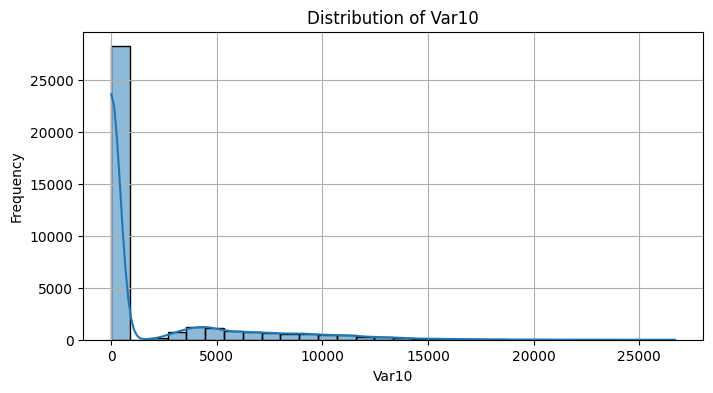

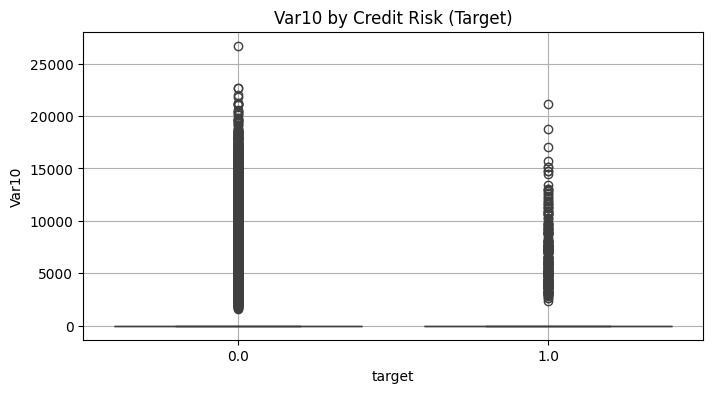

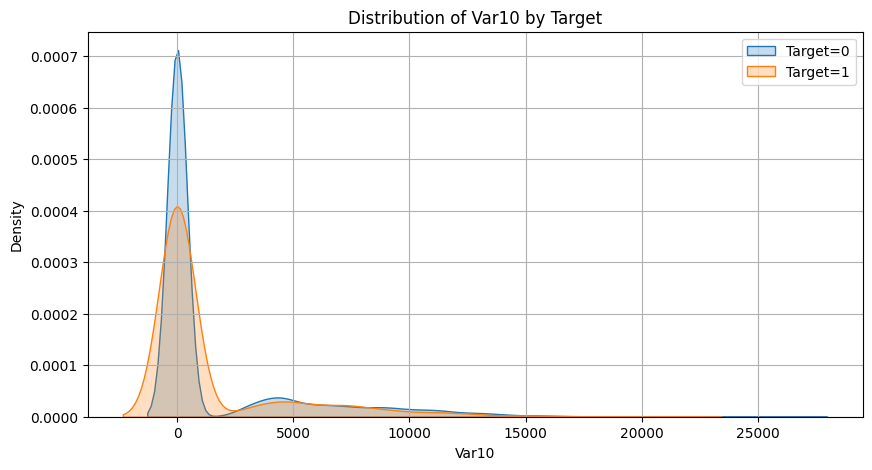


Point-biserial correlation: -0.013595, p-value: 0.009186


In [153]:
numeric_eda_pipeline(df_filtered, 'Var10')

Var10 represents the income of a second applicant, if present. The variable contains many zeros, which correspond to applications with no co-applicant. The distribution is heavily right-skewed, with most values at zero and a long tail up to 26,700.

The median income is 0 for both defaulters and non-defaulters, reflecting that most loans are single-applicant. Among joint applications (non-zero values), non-defaulters tend to report slightly higher incomes. The point-biserial correlation is –0.0136, with a statistically significant p-value (~0.009), suggesting a very weak negative relationship: lower or no co-applicant income is slightly more common among defaulters.

Conclusion:
Var10 alone is not a strong predictor of credit risk, but it provides useful information about application type. Encoding the presence or absence of a second applicant (e.g., Var10 > 0) could enhance model performance in combination with other variables.



# Var11 – Profession of Main Applicant

Var11 is a categorical variable indicating the applicant's profession. It includes seven categories: Pensioneer, Government, Military, Self-Employed, Employee, Business Owner, and Unemployed. This feature provides insight into the applicant's income source and job stability, which can influence creditworthiness and default risk.

In [154]:
profession_map = {
    1: 'Pensioneer',
    2: 'Government',
    3: 'Military',
    4: 'Self-Employed',
    5: 'Employee',
    6: 'Business Owner',
    7: 'Unemployed'
}


In [155]:
df_filtered['Profession'] = df_filtered['Var11'].map(profession_map)


--- EDA for Profession ---
Missing values in Profession: 0

Value counts:


Profession
Employee          25661
Self-Employed      4345
Business Owner     3245
Military           1137
Government         1059
Pensioneer          841
Unemployed          430
Name: count, dtype: int64

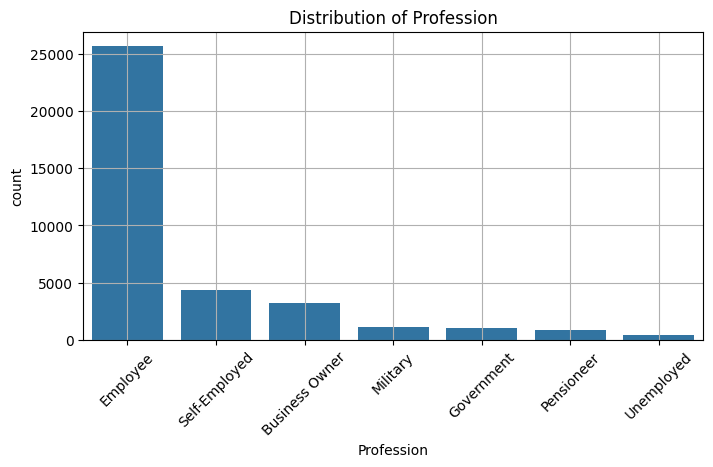

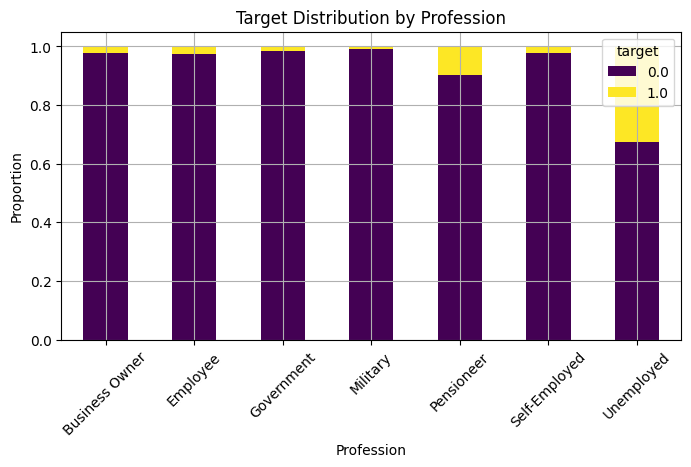


Statistical Relationship:
categorical_variable: Profession
chi2_statistic: 1436.2096679624653
p_value: 3.4961369343777413e-307
cramers_v: 0.1977740987818828
point_biserial_corr (if numeric): None


In [156]:
categorical_eda_pipeline(df_filtered, 'Profession')

The majority of applicants are Employees (code 5), followed by Self-Employed (4) and Business Owners (6). Categories like Unemployed and Pensioneers have much lower representation.

The target distribution varies notably across professions:

Unemployed (7) and Pensioneers (1) show higher default rates,

Government (2) and Military (3) have the lowest.

This is supported by a highly significant chi-squared test (p < 1e-300) and a Cramér’s V of 0.198, suggesting a moderate association between profession and default. The point-biserial correlation is low (≈ 0.021), reflecting that numeric encoding alone doesn’t capture the category differences well.

Conclusion:
Profession (Var11) is an informative categorical feature with clear differences in default risk across groups. It should be preserved and encoded as categorical (e.g., one-hot or ordinal) for modeling.

# Var12 – Profession of Second Applicant

Var12 captures the profession of the second applicant, using the same codes as Var11 (e.g., 1 = Pensioneer, 5 = Employee, etc.). Like income of the second applicant, this variable is often missing or zero for single applicants. When present, it can provide additional insight into household stability and overall creditworthiness.

In [157]:
categorical_eda_pipeline(df_filtered, 'Var12')

--- EDA for Var12 ---
Missing values in Var12: 28043
⚠️ Skipping analysis for Var12 due to missing values.


In [158]:
df_filtered['Var12'].fillna(0, inplace=True)


/var/folders/qz/ctfh_y5s4f5g3k2h_nzprjm00000gn/T/ipykernel_24237/3922774253.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filtered['Var12'].fillna(0, inplace=True)


In [159]:
profession_map_second = {
    0: 'No Co-applicant',
    1: 'Pensioneer',
    2: 'Government',
    3: 'Military',
    4: 'Self-Employed',
    5: 'Employee',
    6: 'Business Owner',
    7: 'Unemployed'
}


In [160]:
df_filtered['Profession_second'] = df_filtered['Var12'].map(profession_map_second)

--- EDA for Profession_second ---
Missing values in Profession_second: 0

Value counts:


Profession_second
No Co-applicant    28043
Employee            6101
Self-Employed       1039
Business Owner       767
Government           273
Pensioneer           183
Military             160
Unemployed           152
Name: count, dtype: int64

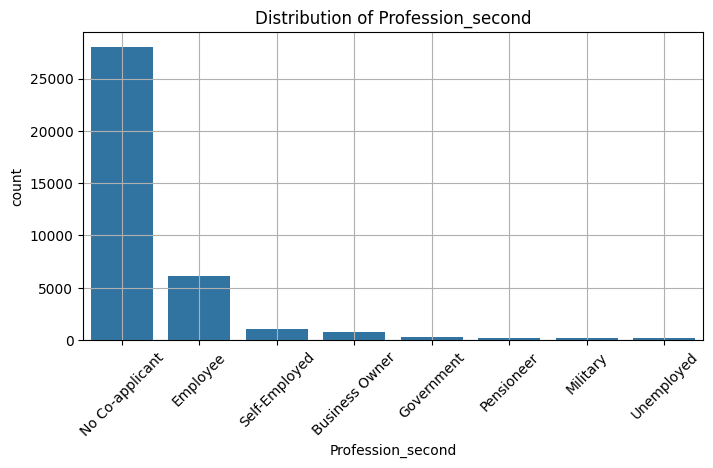

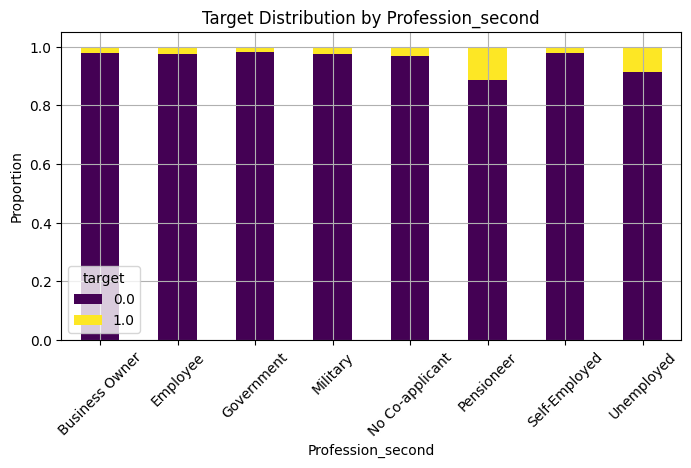


Statistical Relationship:
categorical_variable: Profession_second
chi2_statistic: 71.11259246560783
p_value: 8.801169639331895e-13
cramers_v: 0.04400821432269323
point_biserial_corr (if numeric): None


In [161]:
categorical_eda_pipeline(df_filtered, 'Profession_second')

Var12 identifies the profession of a second applicant when present. After replacing missing values with 0 (mapped as "No Co-applicant"), it’s clear that most applications involve only a single applicant (≈28,000 cases). Among joint applicants, the most common profession is Employee, followed by Self-Employed and Business Owner.

The target distribution shows higher default rates among second applicants who are Unemployed or Pensioneers, while Employees and Government workers show lower default proportions. This is statistically supported by a significant chi-squared test (p < 1e-12). However, the Cramér’s V of 0.044 suggests a very weak effect size.

Conclusion:
While Var12 provides meaningful segmentation for joint applications, its predictive power is limited. Encoding "No Co-applicant" as a distinct category is important to preserve structural differences. It may add value in models when used in combination with Var10 (co-applicant income) and other features

# Var13 – Employment Date (Main Applicant)

Var13 represents the date or duration of employment for the main applicant, typically indicating how long the person has been employed. It reflects job stability, which is a key factor in credit risk assessment. Longer employment duration is generally associated with lower risk, while short or recent employment may signal higher default probability. This variable require transformation (e.g., converting dates to number of months/years) for analysis.

In [162]:
df_filtered['Var13'].values

array(['26Nov2004', '16Sep1996', '06May1989', ..., '28Mar2008',
       '28Oct2006', '03Apr2004'], shape=(36718,), dtype=object)

In [163]:
import pandas as pd
from datetime import datetime

# Convert to datetime format
df_filtered['Var13'] = pd.to_datetime(df_filtered['Var13'], format='%d%b%Y', errors='coerce')

# Calculate duration in years (e.g., from today or a fixed date)
reference_date = pd.to_datetime('today')  # or a specific date like pd.to_datetime('01Jan2017')
df_filtered['Employment_Years'] = ((reference_date - df_filtered['Var13']).dt.days) / 365


In [164]:
df_filtered['Employment_Years'].describe()


count    36154.000000
mean        20.742819
std          7.295863
min          4.416438
25%         14.975342
50%         20.761644
75%         26.484932
max         38.150685
Name: Employment_Years, dtype: float64

In [165]:
df_filtered['Employment_Years'].isnull().sum()

np.int64(564)

In [166]:
median_years = df_filtered['Employment_Years'].median()
df_filtered['Employment_Years'].fillna(median_years, inplace=True)


/var/folders/qz/ctfh_y5s4f5g3k2h_nzprjm00000gn/T/ipykernel_24237/4094246094.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filtered['Employment_Years'].fillna(median_years, inplace=True)


In [167]:
df_filtered['Var13'] = df_filtered['Employment_Years']


`Var13` was transformed from employment start date into employment duration (in years) to reflect applicant job stability.

--- EDA for Employment_Years ---
Missing values in Employment_Years: 0

Descriptive statistics by target:


,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0.0,35591.0,20.741389,7.257029,4.416438,15.046575,20.761644,26.415068,38.150685
1.0,1127.0,20.797399,6.668947,4.553425,16.175342,20.761644,25.554795,37.493151


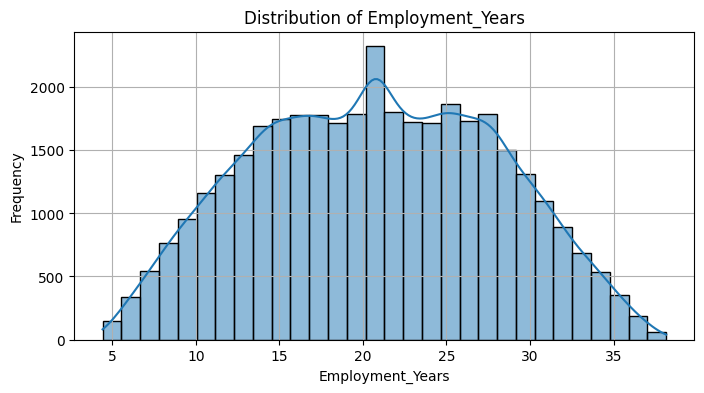

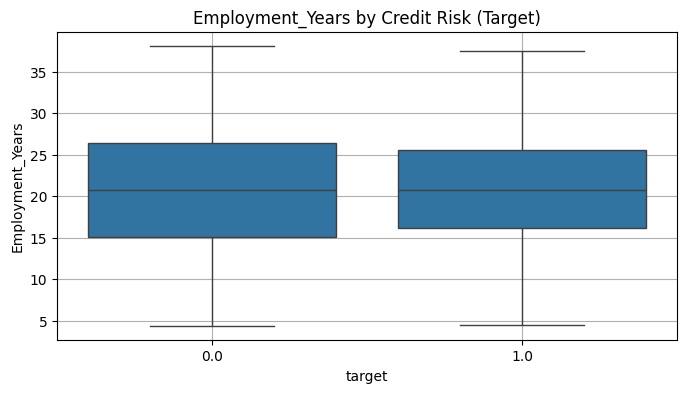

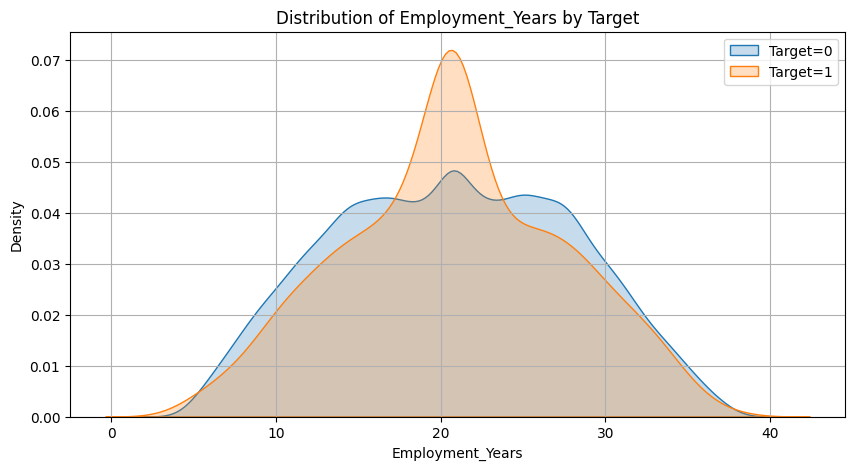


Point-biserial correlation: 0.001334, p-value: 0.798182


In [168]:
numeric_eda_pipeline(df_filtered, 'Employment_Years')

Var13 was converted from employment start date into a numeric variable, Employment_Years, reflecting the number of years the main applicant has been employed. The distribution is roughly symmetric, with most applicants reporting between 10 and 30 years of employment. The median is around 20.7 years.

When comparing by credit risk, both defaulters and non-defaulters have nearly identical employment durations. The boxplot confirms significant overlap, and the point-biserial correlation is effectively zero (r = 0.0013, p ≈ 0.798) — indicating no meaningful relationship between employment duration and default risk in this dataset.

Conclusion:
Although employment duration is often considered important in credit scoring, in this case it appears to have no significant predictive power on its own. It may still be retained for modeling in case of nonlinear interactions or joint effects with other variables.

# Var14 – Marital Status of Main Applicant

Var14 is a categorical variable indicating the marital status of the main applicant. It includes five categories: Single, Married, Informal Relationship, Divorced, and Widowed. Marital status can influence financial stability and may be relevant for assessing credit risk.

In [169]:
marital_status_map = {
    0: 'Single',
    1: 'Married',
    2: 'Informal Relationship',
    3: 'Divorced',
    4: 'Widowed'
}
df_filtered['Marital_Status'] = df_filtered['Var14'].map(marital_status_map)


--- EDA for Marital_Status ---
Missing values in Marital_Status: 0

Value counts:


Marital_Status
Single                   13284
Married                   9989
Informal Relationship     5934
Divorced                  4920
Widowed                   2591
Name: count, dtype: int64

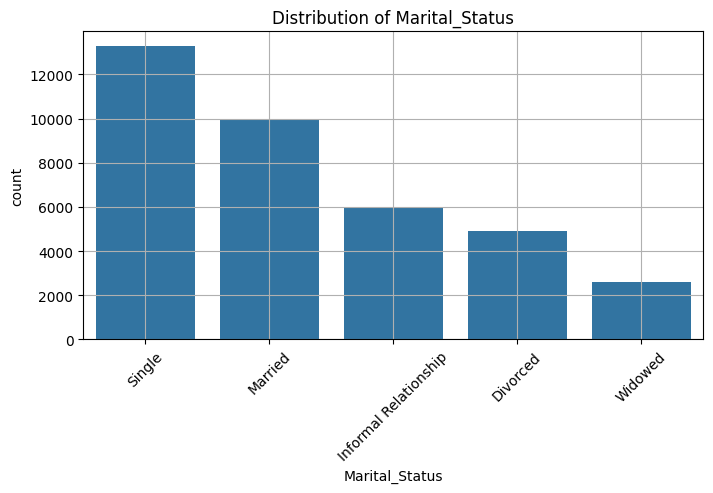

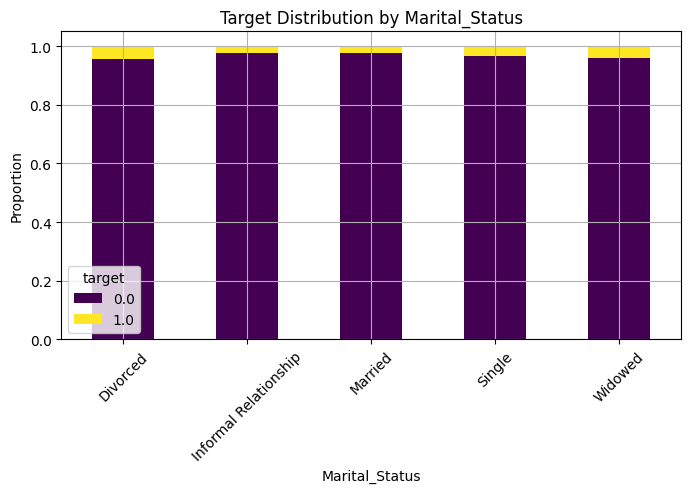


Statistical Relationship:
categorical_variable: Marital_Status
chi2_statistic: 71.21932502737653
p_value: 1.2546303619618148e-14
cramers_v: 0.044041227802758126
point_biserial_corr (if numeric): None


In [170]:
categorical_eda_pipeline(df_filtered, 'Marital_Status')

### Merged 'Divorced' and 'Widowed' into a single category to reduce sparsity and simplify marital status groups.


In [171]:
marital_status_map = {
    0: 'Single',
    1: 'Married',
    2: 'Informal Relationship',
    3: 'Divorced/Widowed',
    4: 'Divorced/Widowed'
}


In [172]:
df_filtered['Marital_Status'] = df_filtered['Var14'].map(marital_status_map)


In [173]:
df_filtered['Var14'] = df_filtered['Var14'].replace({4: 3})


--- EDA for Marital_Status ---
Missing values in Marital_Status: 0

Value counts:


Marital_Status
Single                   13284
Married                   9989
Divorced/Widowed          7511
Informal Relationship     5934
Name: count, dtype: int64

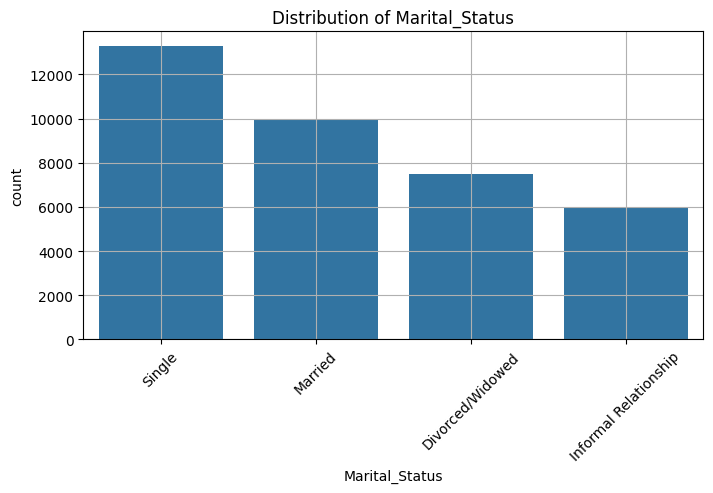

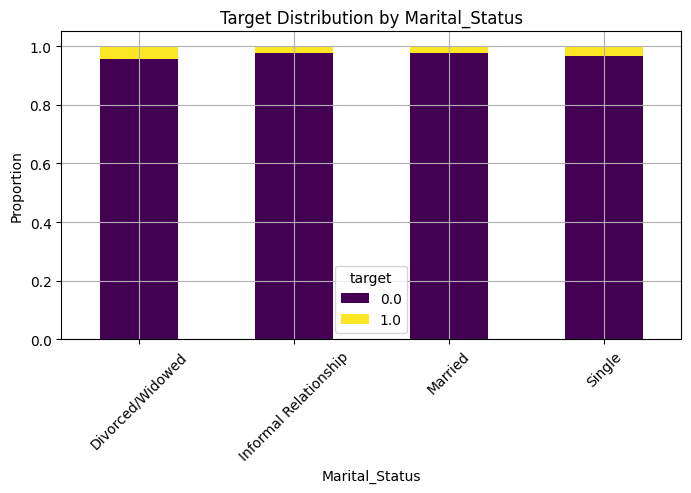


Statistical Relationship:
categorical_variable: Marital_Status
chi2_statistic: 70.4024751709547
p_value: 3.500041276155481e-15
cramers_v: 0.04378793404839835
point_biserial_corr (if numeric): None


In [174]:
categorical_eda_pipeline(df_filtered, 'Marital_Status')

Var14 indicates the applicant’s marital status, categorized as Single, Married, Informal Relationship, or Divorced/Widowed (after combining the two latter groups). The most common status is Single, followed by Married, while Informal Relationship and Divorced/Widowed make up smaller portions of the dataset.

The target distribution by marital status shows only slight differences in default rates. A chi-squared test confirms that the association with credit risk is statistically significant (p < 1e-14), but the Cramér’s V of 0.044 indicates a very weak relationship in practice.

Conclusion:
Marital status contributes weakly to credit risk prediction but may still offer value in interaction with other features. The merged “Divorced/Widowed” group helps simplify the model without significant information loss.



# Var15 – Number of Children (Main Applicant)

Var15 is a numerical variable representing the number of children the main applicant has. It reflects family size and potential financial responsibilities. Higher numbers may indicate increased living expenses, which could affect repayment capacity. This variable is useful for understanding household burden and may be relevant in credit risk modeling.

--- EDA for Var15 ---
Missing values in Var15: 0

Descriptive statistics by target:


,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0.0,35591.0,0.767245,0.984765,0.0,0.0,1.0,1.0,5.0
1.0,1127.0,0.704525,0.935109,0.0,0.0,0.0,1.0,5.0


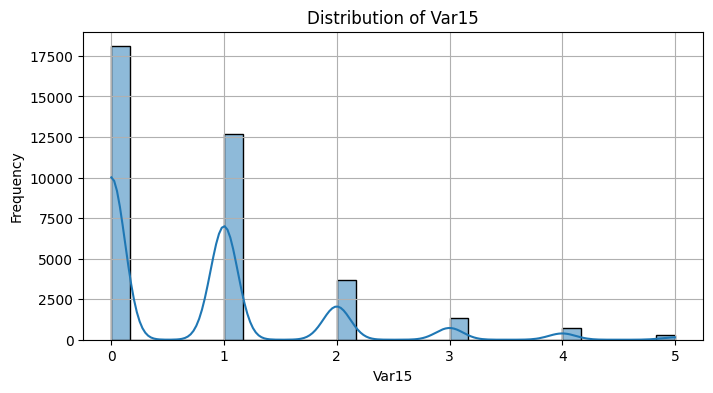

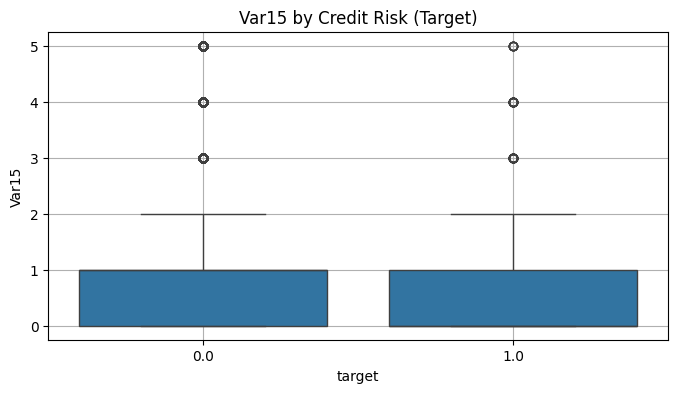

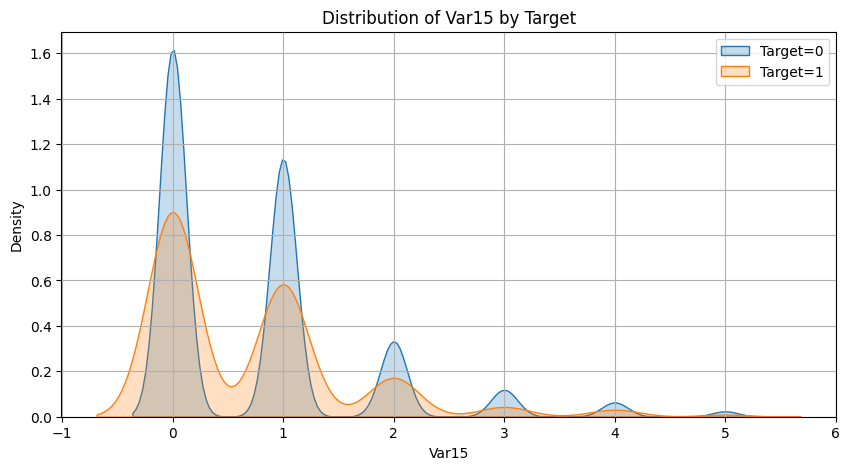


Point-biserial correlation: -0.011002, p-value: 0.035019


In [175]:
numeric_eda_pipeline(df_filtered, 'Var15')

### Grouped number of children into categories to simplify analysis and reduce dimensionality: 0 as 'None', 1 as 'One', 2 as 'Two', and 3 or more as 'Three or more'.


In [176]:
df_filtered['Var15'] = df_filtered['Var15'].replace({4: 3, 5: 3})


In [177]:
children_map = {
    0: 'None',
    1: 'One',
    2: 'Two',
    3: 'Three or more'
}
df_filtered['Children_Group'] = df_filtered['Var15'].map(children_map)


--- EDA for Children_Group ---
Missing values in Children_Group: 0

Value counts:


Children_Group
None             18087
One              12657
Two               3703
Three or more     2271
Name: count, dtype: int64

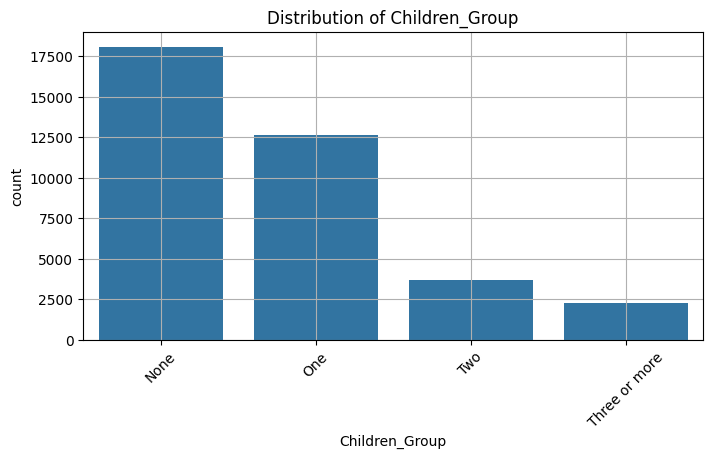

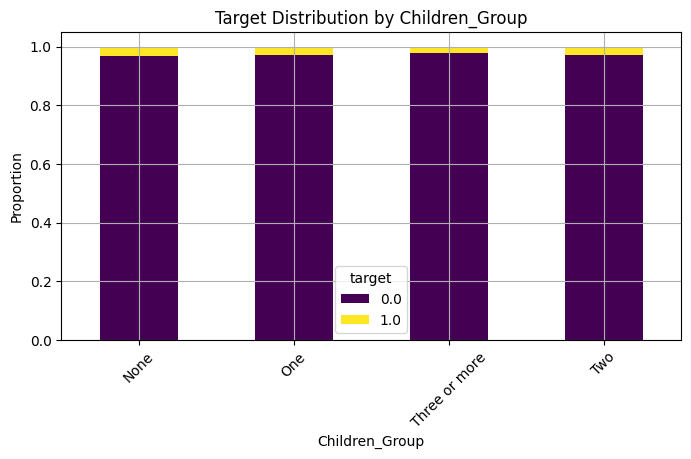


Statistical Relationship:
categorical_variable: Children_Group
chi2_statistic: 5.553083264115752
p_value: 0.1354978999987851
cramers_v: 0.01229780447852324
point_biserial_corr (if numeric): None


In [178]:
categorical_eda_pipeline(df_filtered, 'Children_Group')

Var15 represents the number of children the main applicant has. To improve interpretability, the values were grouped into four categories: None (0), One (1), Two (2), and Three or more (3+).

The majority of applicants have no children (≈18,000) or one child (≈12,600), while larger families are less common. The proportion of defaults is relatively consistent across all groups, with only minor differences.

Statistical testing confirms that the relationship between number of children and credit risk is not significant (p = 0.135), and Cramér’s V = 0.012 indicates a negligible association.

Conclusion:
Number of children appears to have minimal influence on default risk in this dataset. While it may help characterize applicants, it likely offers limited predictive power on its own.

# Var16 – Number of Dependents (Main Applicant)

Var16 indicates how many individuals financially depend on the main applicant (e.g., children, elderly family members). Like the number of children, this feature reflects financial burden and may impact repayment capacity. Higher values could signal tighter household budgets, but its predictive value depends on how it's distributed and correlated with default behavior in your dataset.

--- EDA for Var16 ---
Missing values in Var16: 0

Descriptive statistics by target:


,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0.0,35591.0,1.024613,1.173564,0.0,0.0,1.0,2.0,8.0
1.0,1127.0,0.984916,1.220293,0.0,0.0,1.0,1.0,8.0


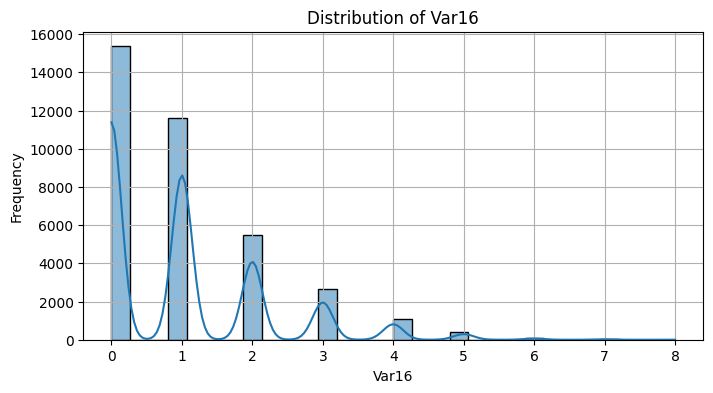

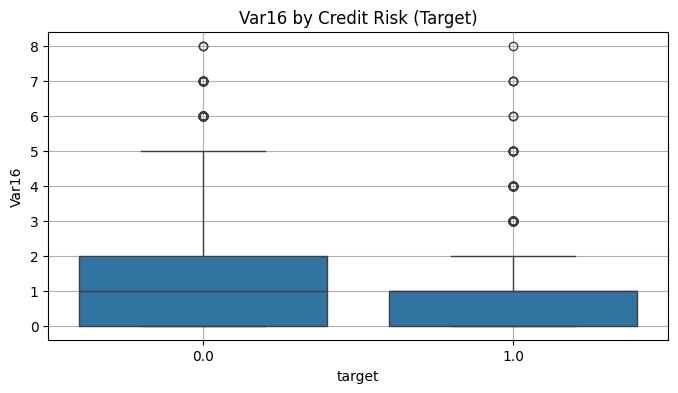

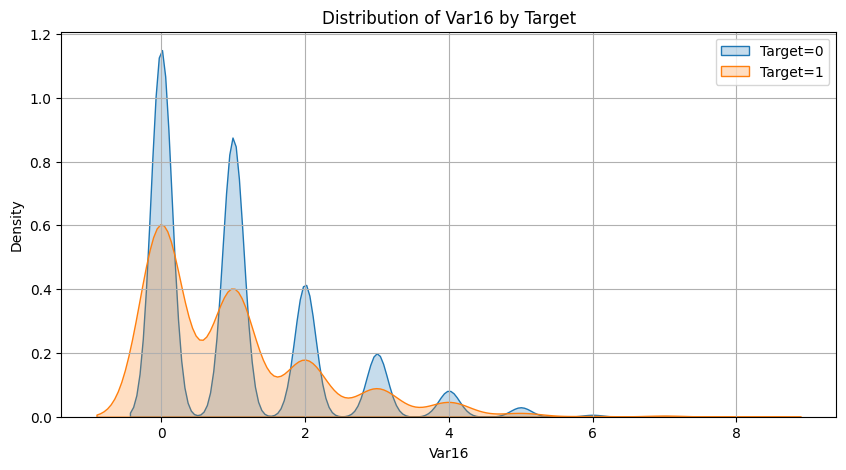


Point-biserial correlation: -0.005827, p-value: 0.264164


In [179]:
numeric_eda_pipeline(df_filtered, 'Var16')

### To simplify analysis and reduce sparsity, higher counts were grouped into a single category.

In [180]:
df_filtered['Var16'] = df_filtered['Var16'].apply(lambda x: 4 if x >= 4 else x)


--- EDA for Var16 ---
Missing values in Var16: 0

Value counts:


Var16
0    15361
1    11618
2     5507
3     2635
4     1597
Name: count, dtype: int64

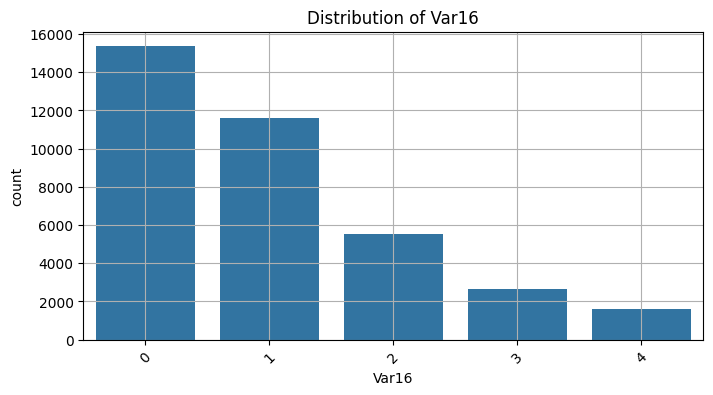

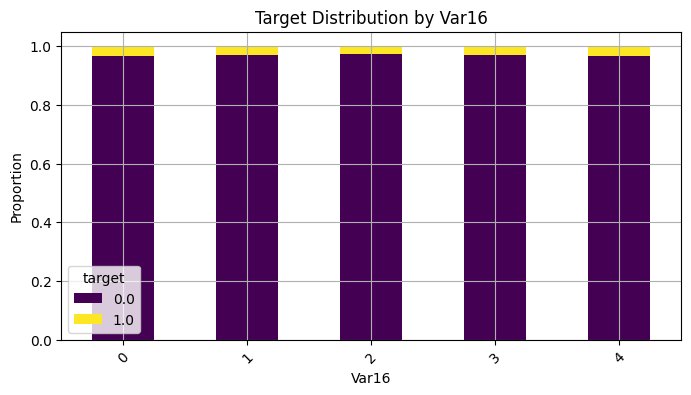


Statistical Relationship:
categorical_variable: Var16
chi2_statistic: 7.484488453013538
p_value: 0.11239523481096757
cramers_v: 0.014277150993745815
point_biserial_corr (if numeric): -0.007120332840649648


In [181]:
categorical_eda_pipeline(df_filtered, 'Var16')

Var16 captures the number of financial dependents the main applicant has. To reduce category sparsity and improve interpretability, values greater than or equal to 4 were grouped into a single category, "4 or more".

Most applicants have 0 or 1 dependent, with progressively fewer having more. The default rates across categories are very similar, showing only minimal variation.

A chi-squared test suggests no statistically significant relationship between number of dependents and credit risk (p = 0.11), and the Cramér’s V value (0.014) confirms a very weak association.

Conclusion:
While number of dependents provides some insight into applicant responsibilities, it shows little direct correlation with default risk and may be more useful when considered alongside other features.

# Var17 – Spendings Estimation

Var17 is a numerical variable representing the estimated monthly or annual spendings of the main applicant. It reflects financial behavior and affordability, which can be useful for credit risk assessment. Higher spending may indicate higher income or higher financial commitments, and analyzing this variable in relation to income and loan amount can offer important insights into repayment capacity.

In [182]:
numeric_eda_pipeline(df_filtered, 'Var17')

--- EDA for Var17 ---
Missing values in Var17: 32
⚠️ Skipping analysis for Var17 due to missing values.


In [183]:
df_filtered['Var17'].fillna(df_filtered['Var17'].median(), inplace=True)


/var/folders/qz/ctfh_y5s4f5g3k2h_nzprjm00000gn/T/ipykernel_24237/2773378745.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filtered['Var17'].fillna(df_filtered['Var17'].median(), inplace=True)


--- EDA for Var17 ---
Missing values in Var17: 0

Descriptive statistics by target:


,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0.0,35591.0,5376.127161,3570.012852,-13817.37,2964.35,4543.39,6840.020,64316.9400
1.0,1127.0,9517.622982,19533.317390,918.78,3253.53,4948.95,8016.995,147140.9359


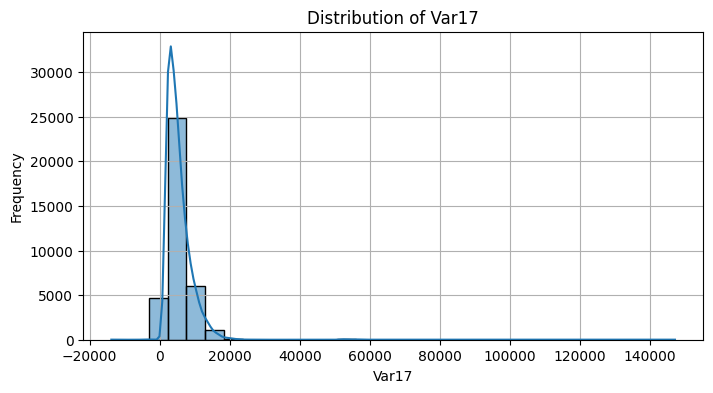

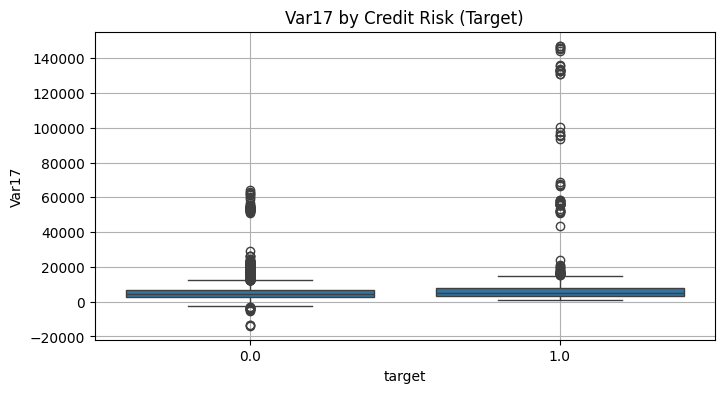

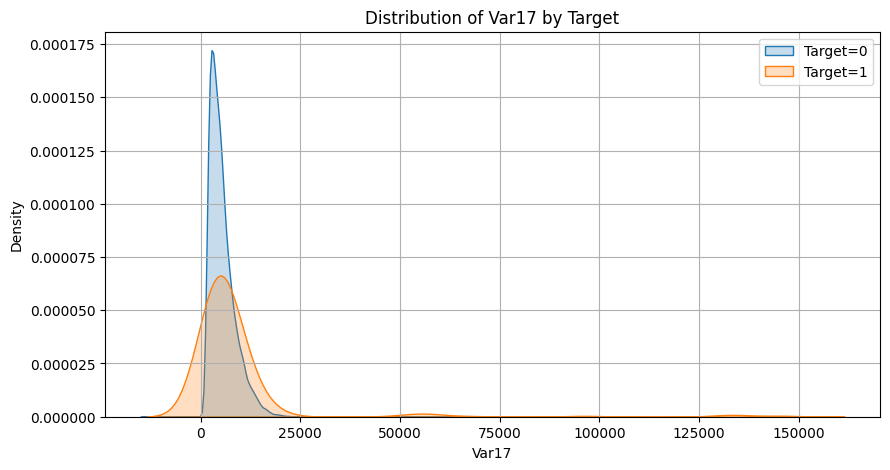


Point-biserial correlation: 0.144131, p-value: 0.000000


In [184]:
numeric_eda_pipeline(df_filtered, 'Var17')

Var17 represents an estimate of the applicant’s expenditures. The distribution is right-skewed, with most values concentrated below 10,000 and a long tail extending beyond 100,000. A few outliers even show negative values, which may require further inspection or filtering.

Boxplots and density plots suggest that applicants who default (target = 1) tend to have slightly higher spendings on average compared to non-defaulters. The point-biserial correlation (≈ 0.14, p < 0.001) indicates a moderate positive association between higher spendings and default risk.

Conclusion:
Spending behavior appears to be an informative feature for credit risk modeling and may reflect affordability constraints or financial discipline. It could be especially valuable when analyzed alongside income or debt ratios.

# Var18 – Property Ownership for Property Renovation

Var18 indicates if the applicant owns the property to be renovated. Ownership may suggest greater stability and lower default risk, especially when the loan is for home renovation

In [185]:
def categorize_property_ownership(row):
    if pd.notnull(row['Var18']):
        return 'Owner' if row['Var18'] == 1 else 'Not Owner'
    elif row['Var2'] != 2:
        return 'Not Applicable'
    else:
        return 'Missing'

df_filtered['Property_Ownership'] = df_filtered.apply(categorize_property_ownership, axis=1)

In [186]:
print(df_filtered['Property_Ownership'].value_counts())


Property_Ownership
Not Applicable    27125
Owner              8082
Not Owner          1511
Name: count, dtype: int64


In [187]:
df_filtered['Var18'] = np.where(
    df_filtered['Var2'] == 2,  # House Renovation loans
    df_filtered['Var18'],      # Keep original 0/1 values
    -1                         # For other loan purposes
)

--- EDA for Property_Ownership ---
Missing values in Property_Ownership: 0

Value counts:


Property_Ownership
Not Applicable    27125
Owner              8082
Not Owner          1511
Name: count, dtype: int64

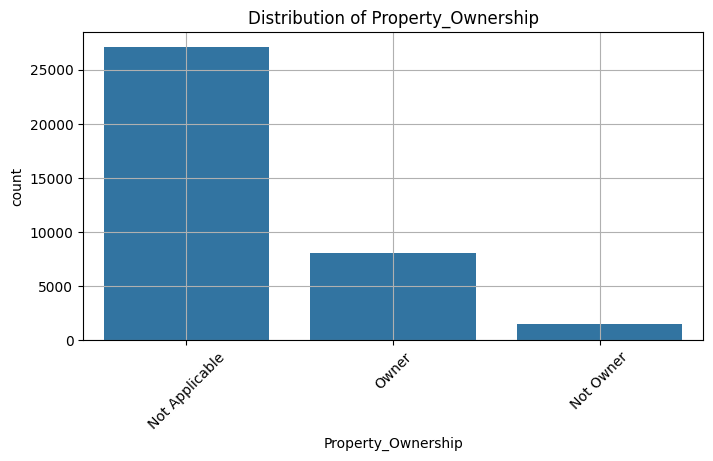

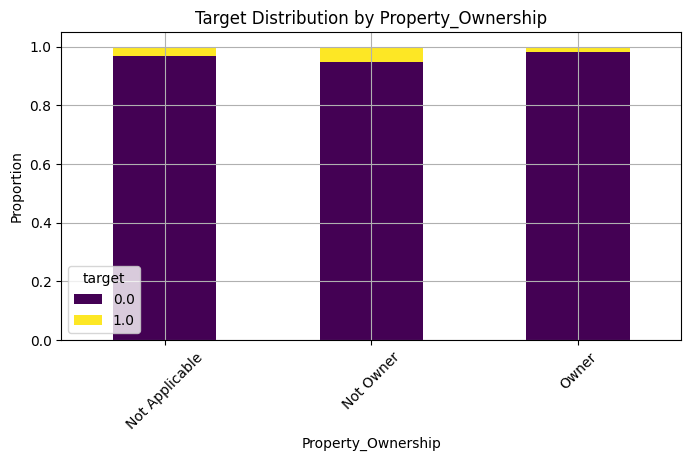


Statistical Relationship:
categorical_variable: Property_Ownership
chi2_statistic: 73.61369310129015
p_value: 1.0351174900793605e-16
cramers_v: 0.04477543299990823
point_biserial_corr (if numeric): None


In [188]:
categorical_eda_pipeline(df_filtered, 'Property_Ownership')

The variable Property_Ownership was derived from Var18, which indicates whether the applicant owns the property being renovated. Missing values were handled by considering the loan purpose: for applicants whose loan purpose is not renovation (e.g., car loan or cash loan), ownership status is considered Not Applicable.

The majority of applicants (around 27,000) fall under the Not Applicable category, meaning their loan is not for renovation.

Roughly 8,000 applicants are Owners, while about 1,500 are Not Owners.

When comparing default rates across categories:

The Not Owner group shows a slightly higher proportion of defaults compared to Owners and Not Applicable cases.

However, the overall differences are small.

A chi-squared test indicates a statistically significant association between property ownership and credit risk (p < 0.0001), but the effect size (Cramér’s V ≈ 0.045) suggests a weak relationship.

Conclusion:
While Property_Ownership may not be a strong standalone predictor of default, the recoding adds interpretability and allows for a more nuanced analysis of housing-related loans. It could still contribute useful signals in combination with other variables in predictive modeling.

# **Var20 – Number of Requests in Last 3 Months (External Data):**  
This variable represents how many times the applicant’s credit information was requested from external sources in the past three months. It is a numerical variable and typically used to assess recent credit-seeking behavior, which may signal financial stress or risk. Higher values could indicate multiple recent credit inquiries, potentially raising red flags during risk assessment.

--- EDA for Var20 ---
Missing values in Var20: 0

Value counts:


Var20
0     23674
1      8677
2      2788
3       915
4       365
5       150
6        72
7        37
8        18
9        10
10        4
11        3
14        2
13        2
15        1
Name: count, dtype: int64

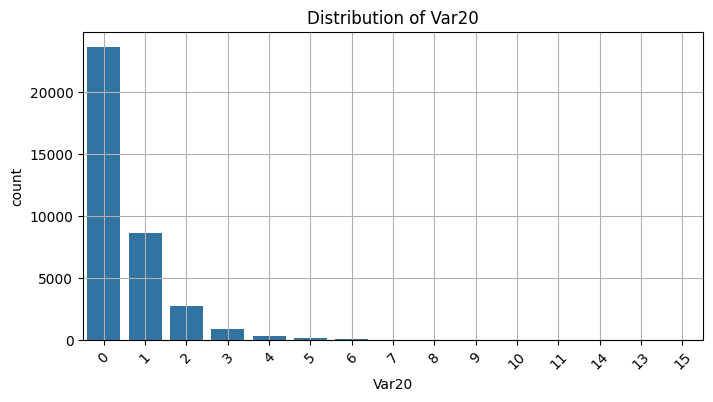

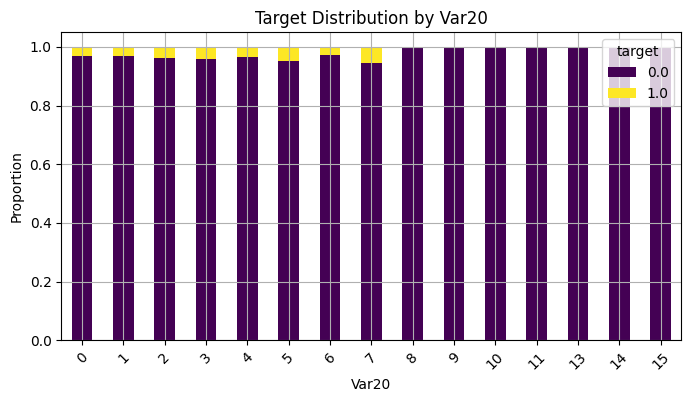


Statistical Relationship:
categorical_variable: Var20
chi2_statistic: 13.416054746352248
p_value: 0.49405619447912696
cramers_v: 0.019114938371773624
point_biserial_corr (if numeric): 0.011670556860608711


In [189]:
categorical_eda_pipeline(df_filtered, 'Var20')

### To reduce category sparsity and improve model robustness, values greater than 4 were grouped into a single category.

In [190]:
df_filtered['Var20'] = df_filtered['Var20'].apply(lambda x: 5 if x > 4 else x)


--- EDA for Var20 ---
Missing values in Var20: 0

Value counts:


Var20
0    23674
1     8677
2     2788
3      915
4      365
5      299
Name: count, dtype: int64

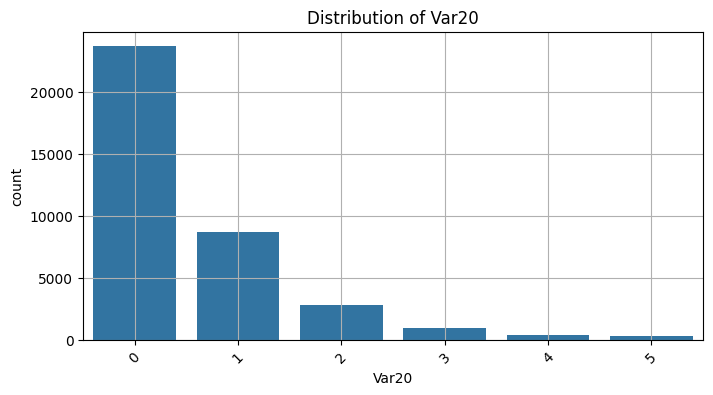

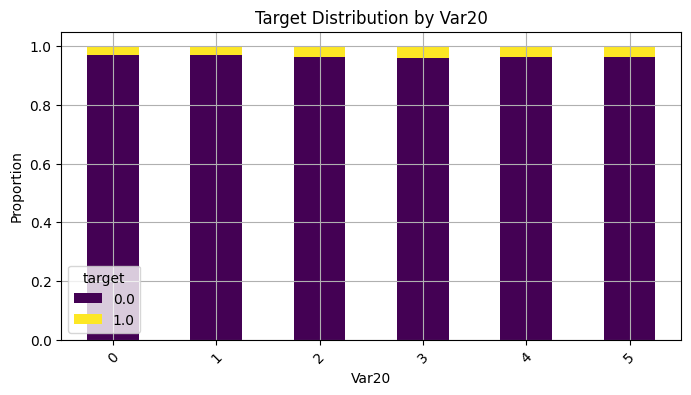


Statistical Relationship:
categorical_variable: Var20
chi2_statistic: 10.537255112149603
p_value: 0.061367259265555356
cramers_v: 0.01694042253884757
point_biserial_corr (if numeric): 0.013085064065177902


In [191]:
categorical_eda_pipeline(df_filtered, 'Var20')

Var20 reflects the number of credit requests made by applicants in the last three months. The majority of applicants (over 23,000) had no credit inquiries, and the frequency declines sharply as the number of requests increases. Due to sparse data, values above 4 were grouped into a single category (“5”).

The default rate remains relatively consistent across all groups, with no clear trend of higher default with increased requests. This suggests that while Var20 captures recent credit activity, it likely has only a weak or indirect relationship with credit risk on its own.

### To reduce category sparsity and improve model robustness, values greater than 4 were grouped into a single category.

In [192]:
for col in ['Var20', 'Var21', 'Var22', 'Var23']:
    df_filtered[col] = df_filtered[col].apply(lambda x: 5 if x > 4 else x)


--- EDA for Var21 ---
Missing values in Var21: 0

Value counts:


Var21
0    17103
1    10576
2     5020
3     2155
4      954
5      910
Name: count, dtype: int64

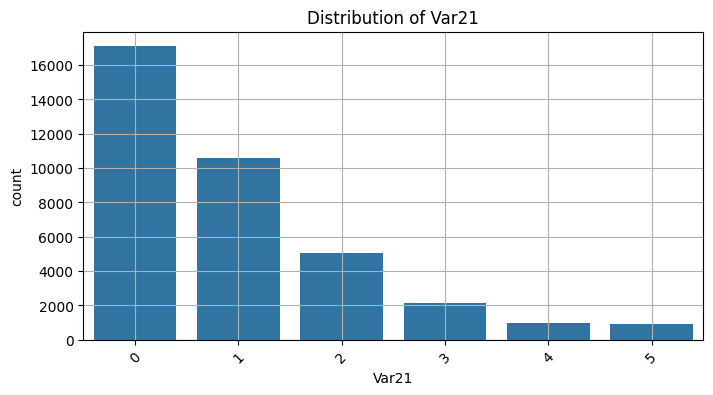

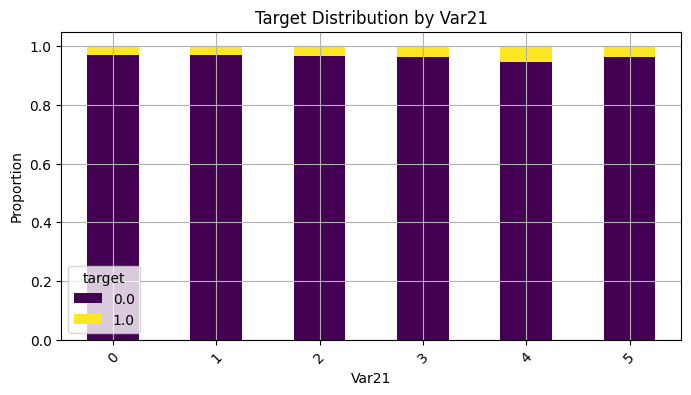


Statistical Relationship:
categorical_variable: Var21
chi2_statistic: 23.240433806392705
p_value: 0.00030364448418255033
cramers_v: 0.025158376168854465
point_biserial_corr (if numeric): 0.02034186700232614


In [193]:
categorical_eda_pipeline(df_filtered, 'Var21')

--- EDA for Var22 ---
Missing values in Var22: 0

Value counts:


Var22
0    13290
1    10772
2     6148
3     3190
5     1689
4     1629
Name: count, dtype: int64

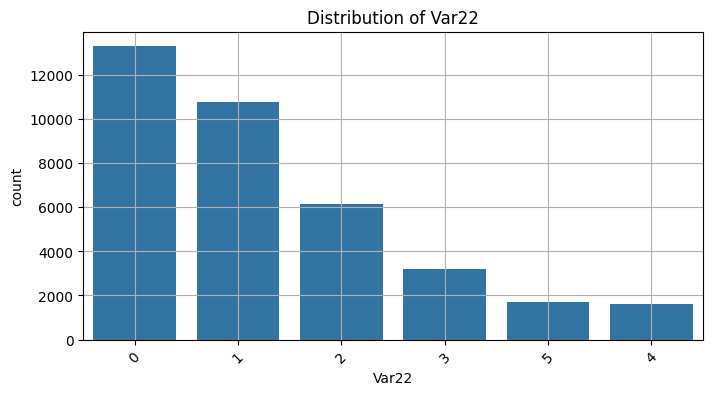

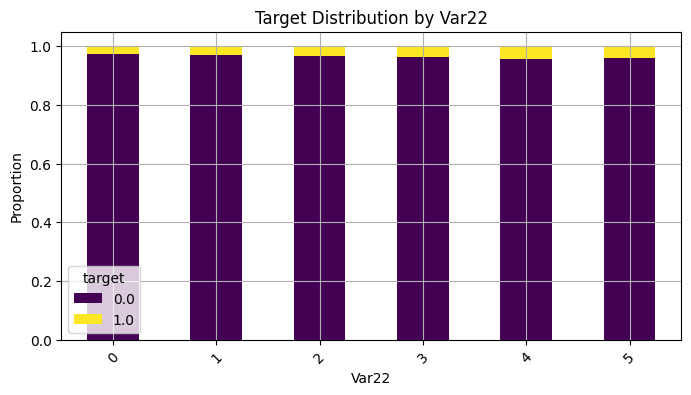


Statistical Relationship:
categorical_variable: Var22
chi2_statistic: 21.751548248228943
p_value: 0.0005837041206134444
cramers_v: 0.024339159610938157
point_biserial_corr (if numeric): 0.02356396443238423


In [194]:
categorical_eda_pipeline(df_filtered, 'Var22')

--- EDA for Var23 ---
Missing values in Var23: 0

Value counts:


Var23
0    10302
1    10294
2     7001
3     4128
5     2653
4     2340
Name: count, dtype: int64

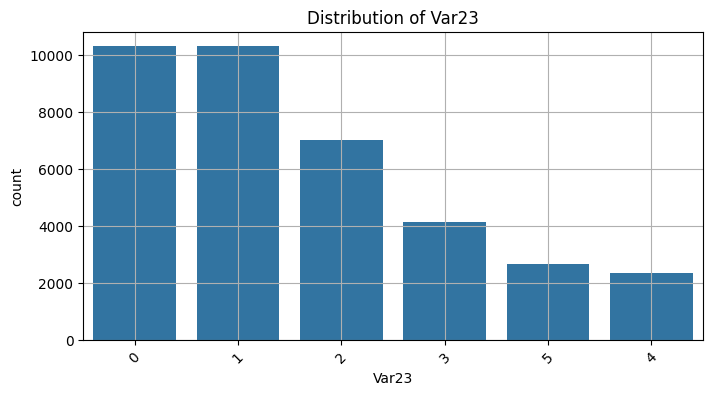

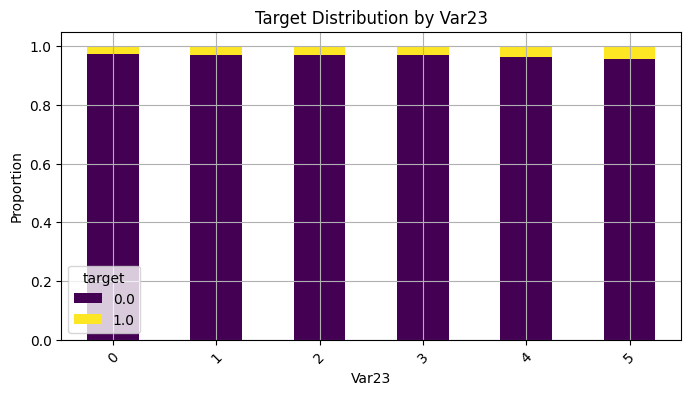


Statistical Relationship:
categorical_variable: Var23
chi2_statistic: 21.475702269783618
p_value: 0.000658427868968794
cramers_v: 0.024184336583906813
point_biserial_corr (if numeric): 0.022178328767883213


In [195]:
categorical_eda_pipeline(df_filtered, 'Var23')

# Var24 – Credit Card Limit 
Var24 represents the maximum credit limit available to the applicant on their credit card. It’s a continuous numerical variable and can indicate overall creditworthiness, with higher limits generally reflecting stronger financial standing.

--- EDA for Var24 ---
Missing values in Var24: 0

Descriptive statistics by target:


,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0.0,35591.0,7762.979405,20991.593670,0.0,0.0,0.0,0.0,190800.0
1.0,1127.0,6602.129547,18595.272296,0.0,0.0,0.0,0.0,144600.0


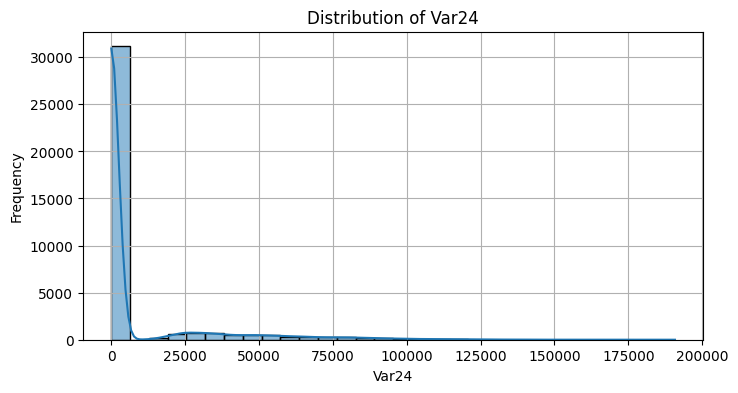

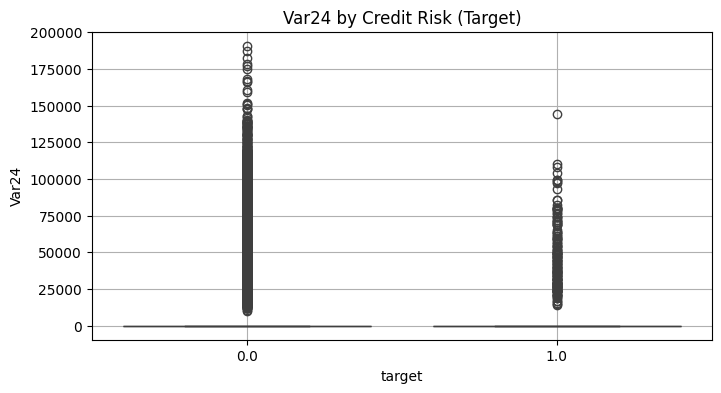

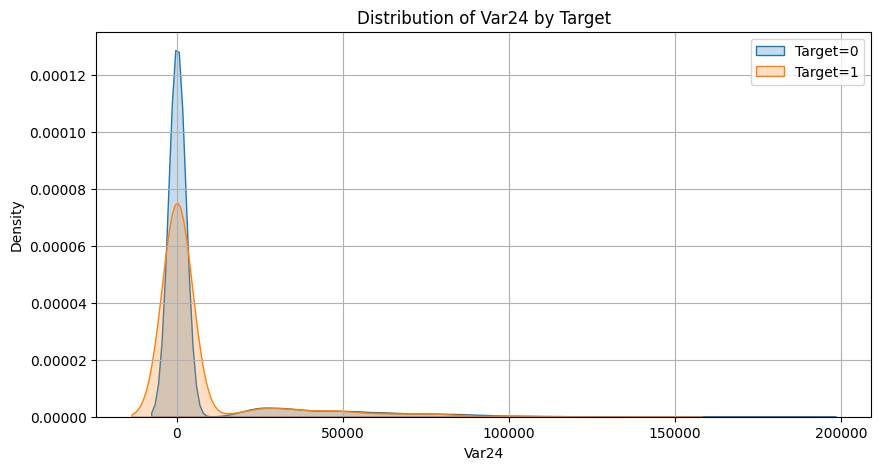


Point-biserial correlation: -0.009570, p-value: 0.066686


In [196]:
numeric_eda_pipeline(df_filtered,'Var24')

### Grouped `Var24` into credit limit categories (`No Credit Card`, `Low`, `Medium`, `High`) to simplify analysis and better capture credit capacity patterns.


In [197]:
def categorize_credit_limit(x):
    if x == 0:
        return 'No Credit Card'
    elif x <= 5000:
        return 'Low Limit'
    elif x <= 15000:
        return 'Medium Limit'
    else:
        return 'High Limit'

df_filtered['Var24_category'] = df_filtered['Var24'].apply(categorize_credit_limit)


In [198]:
# Define the mapping
credit_limit_map = {
    'No Credit Card': 0,
    'Low Limit': 1,
    'Medium Limit': 2,
    'High Limit': 3  # You mentioned mapping to 0,1,2 — so Medium & High both become 2
}

# Apply the mapping
df_filtered['Var24'] = df_filtered['Var24_category'].map(credit_limit_map)


--- EDA for Var24_category ---
Missing values in Var24_category: 0

Value counts:


Var24_category
No Credit Card    31155
High Limit         5523
Medium Limit         40
Name: count, dtype: int64

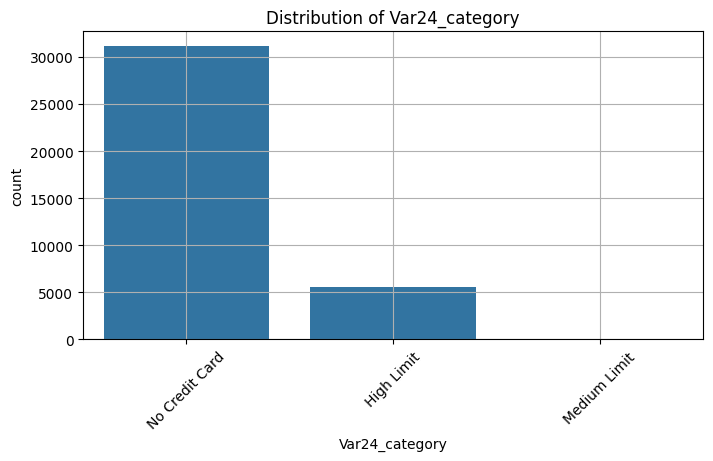

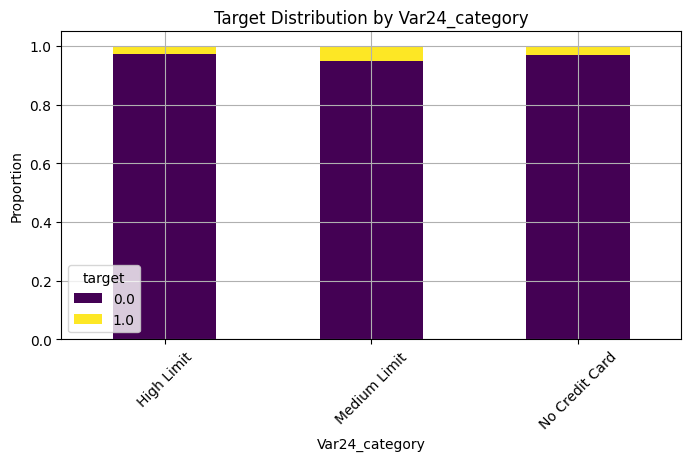


Statistical Relationship:
categorical_variable: Var24_category
chi2_statistic: 1.9880476174923603
p_value: 0.37008454155815296
cramers_v: 0.007358238873943137
point_biserial_corr (if numeric): None


In [199]:
categorical_eda_pipeline(df_filtered, 'Var24_category')

Most applicants have no credit card limit. Among those who do, a small portion holds high or medium limits. Categorizing this variable into "No Credit Card," "Medium Limit," and "High Limit" helps simplify analysis, but the credit limit shows very weak association with default risk — both from visual inspection and statistical results (Cramér’s V ≈ 0.007 and p-value ≈ 0.37). This suggests Var24 alone may not be a strong predictor of credit risk, though it could still be useful in combination with other features.

# Var25 – Amount on Current Account
represents the current balance held by the applicant in their bank account. It's a numerical variable that reflects financial liquidity and can be indicative of financial stability. High values may suggest stronger financial standing.

In [200]:
numeric_eda_pipeline(df_filtered, 'Var25')

--- EDA for Var25 ---
Missing values in Var25: 7401
⚠️ Skipping analysis for Var25 due to missing values.


In [201]:
# Create binned categories for Var25
def categorize_var25(val):
    if pd.isnull(val):
        return 'Missing'
    elif val < 1000:
        return 'Low'
    elif val < 5000:
        return 'Medium'
    else:
        return 'High'

# Apply the function
df_filtered['Var25_category'] = df_filtered['Var25'].apply(categorize_var25)


In [202]:
# Define the mapping
var25_map = {
    'Missing': 0,
    'Low': 1,
    'Medium': 2,
    'High': 3
}

# Apply the mapping
df_filtered['Var25'] = df_filtered['Var25_category'].map(var25_map)


--- EDA for Var25_category ---
Missing values in Var25_category: 0

Value counts:


Var25_category
High       21837
Missing     7401
Medium      7328
Low          152
Name: count, dtype: int64

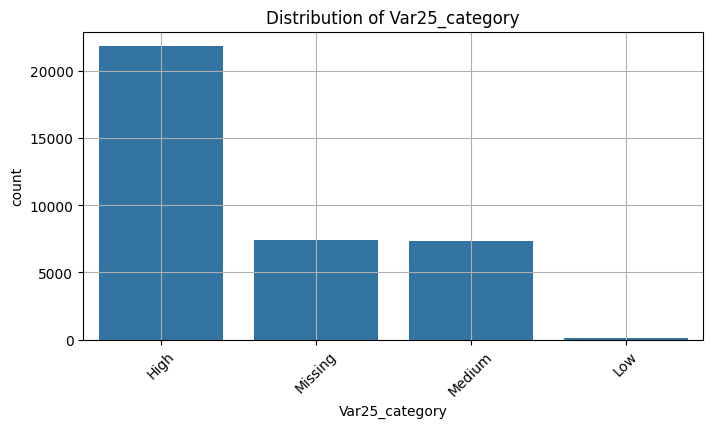

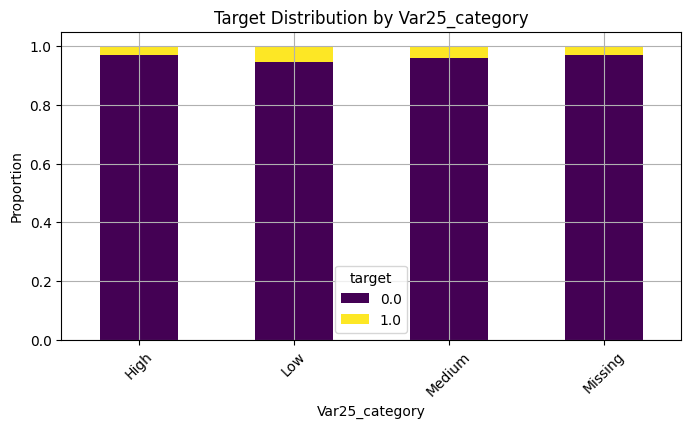


Statistical Relationship:
categorical_variable: Var25_category
chi2_statistic: 22.51444200314765
p_value: 5.097588262789192e-05
cramers_v: 0.024762305949470296
point_biserial_corr (if numeric): None


In [203]:
categorical_eda_pipeline(df_filtered, 'Var25_category')

Distribution:
Most applicants fall into the "High" balance category (≈21,800), followed by balanced counts in "Medium" and "Missing" (~7,300–7,400 each). Very few applicants (~150) fall into the "Low" category, indicating it's an edge case or rare behavior.

Target Relationship:
While default rates vary slightly across categories, the differences are not dramatic. However, the "Low" balance group shows a slightly higher proportion of defaults, consistent with financial vulnerability. The "High" balance group seems to have the lowest default rate, suggesting some protective effect from having more liquidity.

Statistical Test:

Chi² = 22.51, p-value ≈ 0.00005 ⇒ statistically significant.

Cramér’s V = 0.025 ⇒ very weak practical effect, but worth exploring in combination with other features.

Conclusion:
Creating a categorical version of Var25 is justified, especially with the inclusion of a "Missing" category, which captures a meaningful segment of the data. While the variable may not be strongly predictive on its own, it could still contribute value when combined with other features in a model.

# Var26 – Amount on Savings Account 
represents the balance the applicant holds in a savings account. It reflects their financial reserves and can indicate financial stability or risk. Higher balances may correlate with lower credit risk, while lower or missing values might signal vulnerability.

In [204]:
numeric_eda_pipeline(df_filtered, 'Var26')

--- EDA for Var26 ---
Missing values in Var26: 14649
⚠️ Skipping analysis for Var26 due to missing values.


In [205]:
# Create a new column Var26_category
def categorize_var26(x, q1, q3):
    if pd.isnull(x):
        return 'Missing'
    elif x <= q1:
        return 'Low'
    elif x <= q3:
        return 'Medium'
    else:
        return 'High'

# Calculate quartiles (excluding NaNs)
q1 = df_filtered['Var26'].quantile(0.25)
q3 = df_filtered['Var26'].quantile(0.75)

# Apply the categorization
df_filtered['Var26_category'] = df_filtered['Var26'].apply(lambda x: categorize_var26(x, q1, q3))


In [206]:
# Define the mapping
var26_map = {
    'Missing': 0,
    'Low': 1,
    'Medium': 2,
    'High': 3
}

# Apply the mapping
df_filtered['Var26'] = df_filtered['Var26_category'].map(var26_map)


--- EDA for Var26_category ---
Missing values in Var26_category: 0

Value counts:


Var26_category
Missing    14649
Medium     11034
Low         5518
High        5517
Name: count, dtype: int64

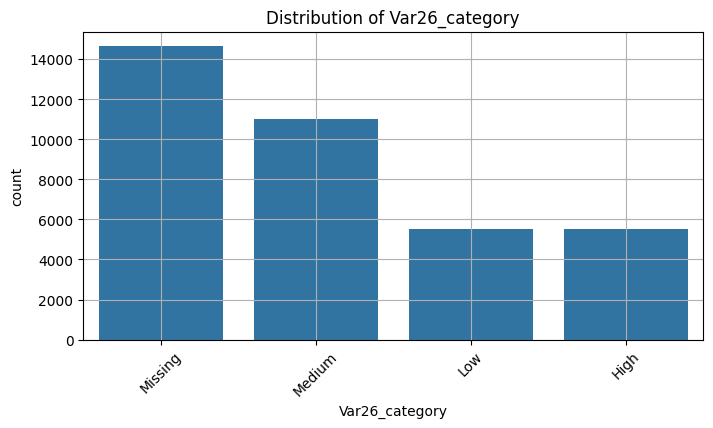

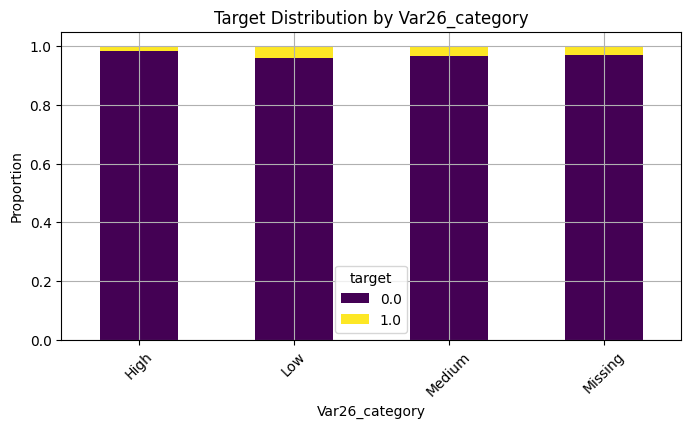


Statistical Relationship:
categorical_variable: Var26_category
chi2_statistic: 50.122652291693036
p_value: 7.522817020907785e-11
cramers_v: 0.036946858157065714
point_biserial_corr (if numeric): None


In [207]:
categorical_eda_pipeline(df_filtered, 'Var26_category')


Var26 was categorized into Low, Medium, High, and Missing. Nearly 14,600 records had missing values, indicating a significant portion of applicants did not report savings information. The most populated non-missing category was Medium.

From the target distribution plot, we observe that:

The default rate is slightly higher among individuals with low or missing savings.

Applicants with high savings show a lower default tendency, which aligns with financial intuition—higher savings can buffer against default risk.

Statistical tests support this:

Chi-square test shows a significant relationship (p-value < 0.0001), suggesting savings level may influence credit risk.

Cramér’s V = 0.037 indicates a weak but non-negligible association.

Overall, Var26 could be a weak but useful categorical predictor for credit risk.

# Var27 – Arrear in Last 3 Months (Indicator):
This variable indicates whether the applicant was in arrears (late on payments) in the past 3 months. It is likely binary:

0 = No arrears

1 = Has been in arrears

This feature is directly linked to recent credit behavior and can be strongly predictive of credit risk.

--- EDA for Var27 ---
Missing values in Var27: 0

Value counts:


Var27
0    36259
1      459
Name: count, dtype: int64

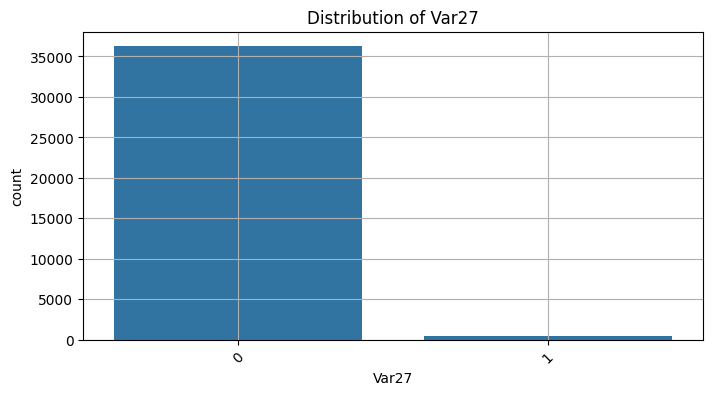

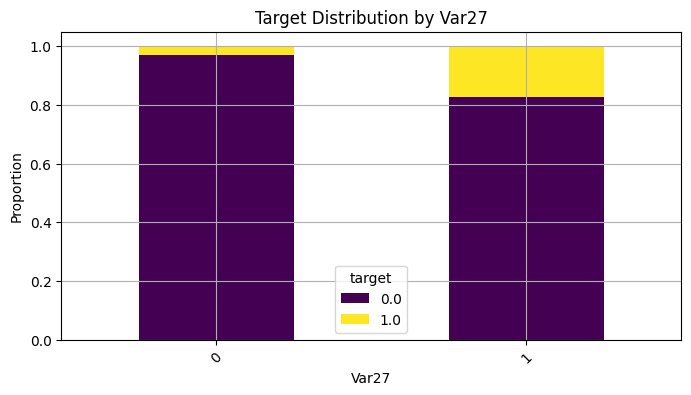


Statistical Relationship:
categorical_variable: Var27
chi2_statistic: 307.66238441440225
p_value: 7.054473992890901e-69
cramers_v: 0.09153721437726103
point_biserial_corr (if numeric): 0.09224777758205073


In [208]:
categorical_eda_pipeline(df_filtered, 'Var27')

Distribution:
Most applicants (~36,000) had no arrears in the last 3 months (Var27 = 0), while a very small number (~700) did (Var27 = 1), indicating arrears are rare in the dataset.

Target Relationship:
Despite being a minority, applicants with arrears show a much higher default rate—about 17% default compared to just under 3% for those with no arrears.

Statistical Significance:
The chi-squared test confirms a strong and statistically significant association between recent arrears and default (p-value ≈ 0, Cramér’s V ≈ 0.092), and the point-biserial correlation (≈ 0.092) suggests a moderate positive relationship with credit risk.

Conclusion:
Var27 is a highly predictive feature—recent arrears are strongly associated with increased default risk and should be retained as an important indicator in modeling.

# Var28 – Arrear in Last 12 Months (Indicator):
This variable shows whether the applicant has had any arrears (late payments) in the past year.

0 = No arrears in the last 12 months

1 = At least one arrear in the last 12 months

It's a longer-term version of Var27 and helps assess the applicant’s credit behavior over time. It may show weaker but still relevant correlation with default risk compared to recent arrears.

--- EDA for Var28 ---
Missing values in Var28: 0

Value counts:


Var28
0    35100
1     1618
Name: count, dtype: int64

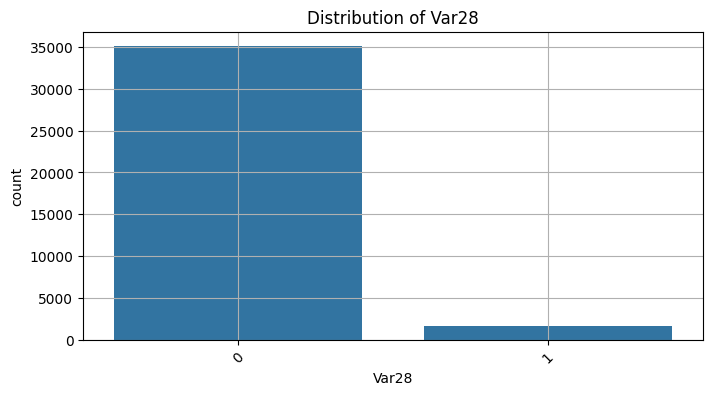

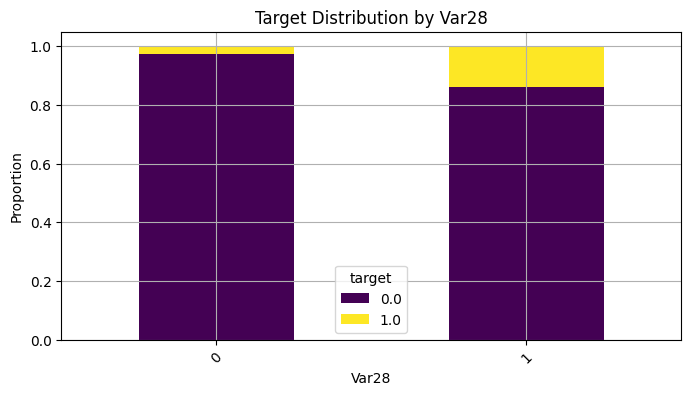


Statistical Relationship:
categorical_variable: Var28
chi2_statistic: 649.1816426002616
p_value: 3.3657972283006227e-143
cramers_v: 0.1329669192199641
point_biserial_corr (if numeric): 0.1333515766730218


In [209]:
categorical_eda_pipeline(df_filtered, 'Var28')

Distribution:
A large majority of applicants (about 35,000) had no arrears, while a much smaller group (around 2,000) had at least one arrear in the past 12 months.

Target Distribution:
The default rate is substantially higher among applicants with arrears. Visually, the yellow bar (defaults) is much taller for arrear=1 than for arrear=0, suggesting a strong link between recent arrears and credit risk.

Statistical Significance:

Chi-squared test: Very significant (p-value ≈ 0), confirming that arrears are strongly associated with default.

Cramér’s V = 0.13, indicating a moderate effect size.

Point-biserial correlation = 0.13, further validating the positive relationship between arrears and default.

Conclusion:
Var28 is a strong predictor of default and captures important behavioral risk information. Applicants with a history of arrears in the past year are significantly more likely to default.

# Var29 - Credit Bureau Score (External Data):
Represents the applicant’s creditworthiness as assessed by an external bureau—higher scores indicate lower credit risk.

--- EDA for Var29 ---
Missing values in Var29: 0

Value counts:


Var29
0      19833
10     12479
20      2724
30       878
40       381
50       164
60        95
70        59
80        39
90        22
120        8
110        7
100        7
130        7
150        3
140        3
180        2
250        2
160        1
170        1
190        1
210        1
240        1
Name: count, dtype: int64

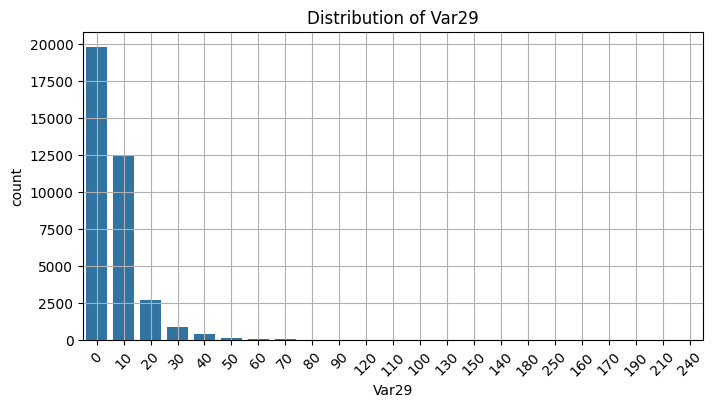

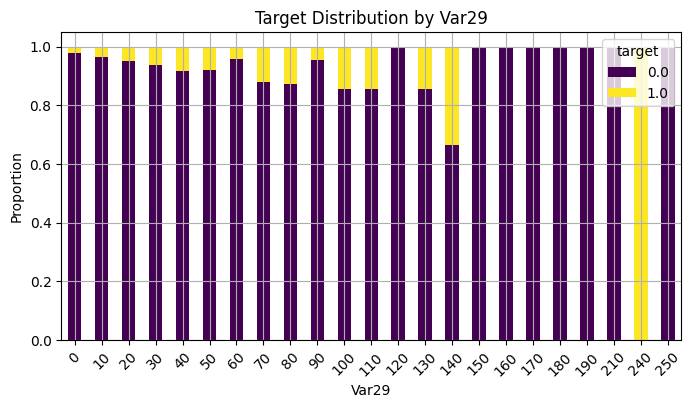


Statistical Relationship:
categorical_variable: Var29
chi2_statistic: 255.60622311828914
p_value: 1.0877837138277736e-41
cramers_v: 0.08343460281077814
point_biserial_corr (if numeric): 0.07162640014050475


In [210]:
categorical_eda_pipeline(df_filtered, 'Var29')

In [211]:
def bin_var29(x):
    if x == 0:
        return "Very Low"
    elif x <= 20:
        return "Low"
    elif x <= 60:
        return "Medium"
    else:
        return "High"

df_filtered['Var29_binned'] = df_filtered['Var29'].apply(bin_var29)


In [212]:
# Define the mapping
var29_map = {
    'Very Low': 0,
    'Low': 1,
    'Medium': 2,
    'High': 3
}

# Apply the mapping
df_filtered['Var29'] = df_filtered['Var29_binned'].map(var29_map)


--- EDA for Var29_binned ---
Missing values in Var29_binned: 0

Value counts:


Var29_binned
Very Low    19833
Low         15203
Medium       1518
High          164
Name: count, dtype: int64

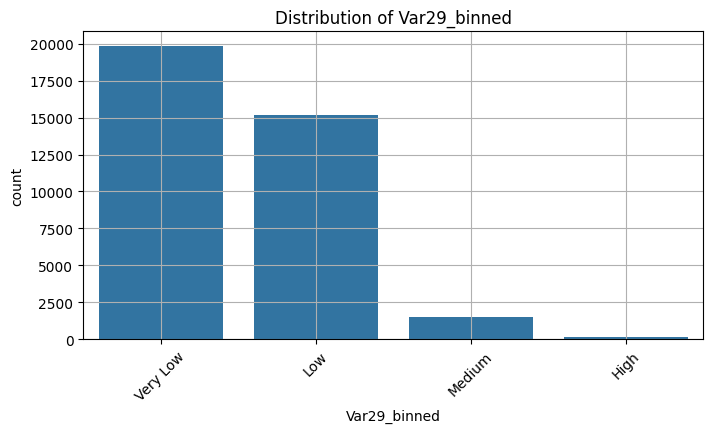

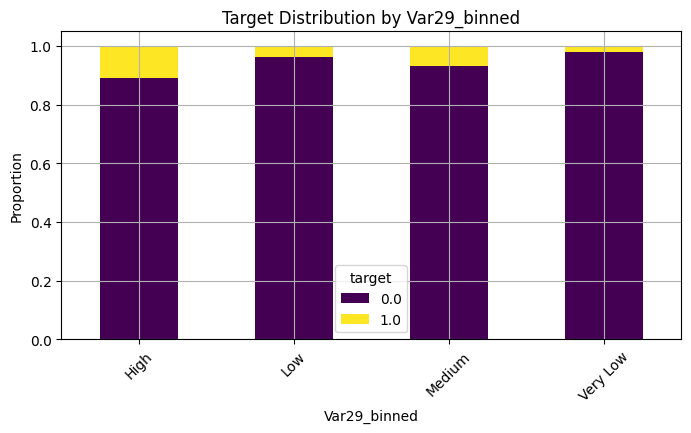


Statistical Relationship:
categorical_variable: Var29_binned
chi2_statistic: 193.67101731503462
p_value: 9.83038745572297e-42
cramers_v: 0.07262611419053891
point_biserial_corr (if numeric): None


In [213]:
categorical_eda_pipeline(df_filtered, 'Var29_binned')

Most applicants fall into the “Very Low” and “Low” categories, showing that low credit bureau scores are common in this dataset.

As the score increases to “Medium” and “High,” the number of applicants drops significantly—especially for the “High” category, which is rare.

Default rates are higher among those with lower scores, with the “High” category showing the highest proportion of defaults, though it’s based on very few observations.

The Chi-squared test is highly significant (p < 0.001), and Cramér’s V of 0.073 suggests a moderate association between credit bureau score and default risk.

Conclusion: Var29 is a useful predictor—lower scores correlate with lower creditworthiness. Binning helps simplify the interpretation while preserving predictive value.

# Var30 – Average Income (External Data):
This variable reflects the average income estimate of the applicant from external sources. It provides an indirect view of financial capacity based on regional or profile-based external data, not necessarily self-reported income.

--- EDA for Var30 ---
Missing values in Var30: 0

Descriptive statistics by target:


,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0.0,35591.0,8146.388076,3191.100338,3899.0,5035.0,8569.0,11839.0,12832.0
1.0,1127.0,8186.690328,3244.066586,3899.0,5035.0,8569.0,11839.0,12832.0


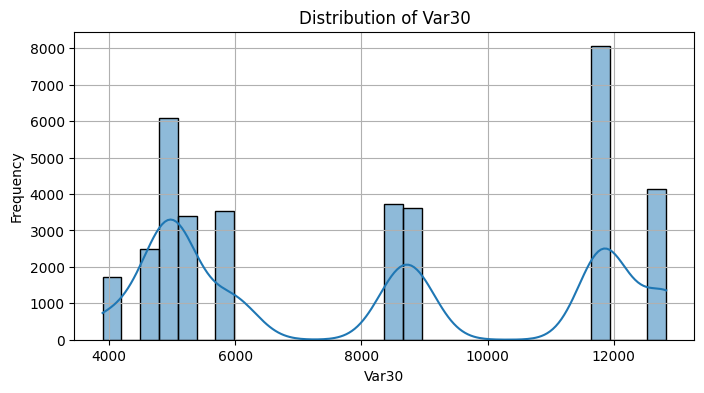

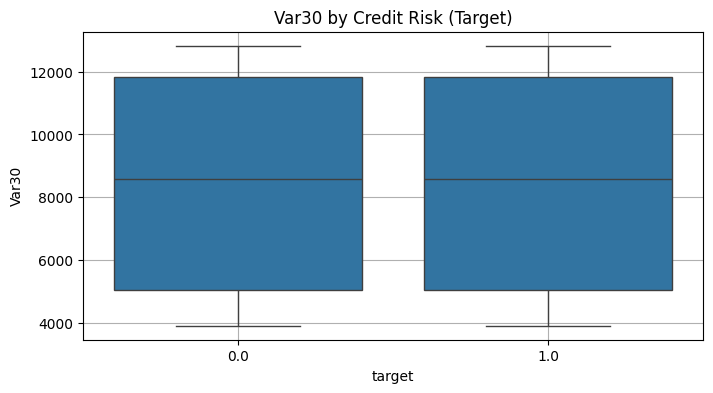

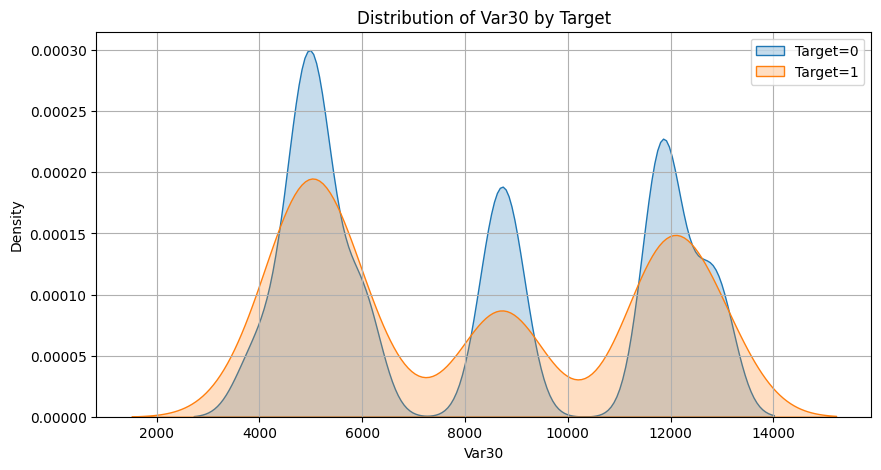


Point-biserial correlation: 0.002177, p-value: 0.676525


In [214]:
numeric_eda_pipeline(df_filtered, 'Var30')

In [215]:
# Create income bands
def categorize_income(val):
    if val < 7000:
        return 'Low'
    elif val < 10000:
        return 'Medium'
    else:
        return 'High'

df_filtered['Var30_category'] = df_filtered['Var30'].apply(categorize_income)


In [216]:
# Define the mapping
income_map = {
    'Low': 0,
    'Medium': 1,
    'High': 2
}

# Apply the mapping
df_filtered['Var30'] = df_filtered['Var30_category'].map(income_map)


--- EDA for Var30_category ---
Missing values in Var30_category: 0

Value counts:


Var30_category
Low       17191
High      12188
Medium     7339
Name: count, dtype: int64

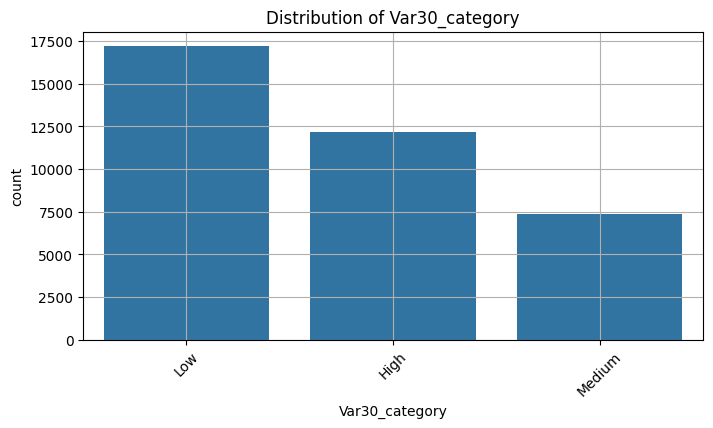

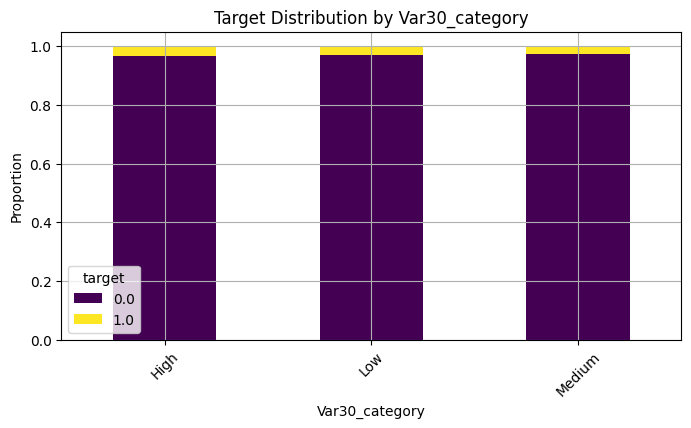


Statistical Relationship:
categorical_variable: Var30_category
chi2_statistic: 4.329892898240686
p_value: 0.11475607972175395
cramers_v: 0.010859230915646183
point_biserial_corr (if numeric): None


In [217]:
categorical_eda_pipeline(df_filtered, 'Var30_category')

In [218]:
# Select the desired columns
selected_columns = ['target', 'Var1_binary'] + [f'Var{i}' for i in range(2, 31)]

# Create a new DataFrame with only those columns
df_selected = df_filtered[selected_columns]

# Save to CSV
df_selected.to_csv('selected_data.csv', index=False)


In [219]:
Df = pd.read_csv('/Users/shokoufehnaseri/Library/CloudStorage/OneDrive-Personal/fourth_semester/UB_presentations_2025/ING-credit_risk/Data/Processed/selected_data.csv')

In [220]:
Df.head()

,target,Var1_binary,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,...,Var21,Var22,Var23,Var24,Var25,Var26,Var27,Var28,Var29,Var30
0,0.0,0,2,1,7800,99,1,108.73,0.0,5640,...,1,1,1,0,3,1,0,0,0,0
1,0.0,0,1,2,11100,78,1,195.99,11200.0,3000,...,0,0,0,2,3,1,0,0,0,0
2,0.0,1,3,1,2400,15,1,248.34,0.0,6240,...,2,2,2,0,3,1,0,0,1,0
3,0.0,1,1,2,11800,30,6,3538.68,12400.0,4560,...,0,0,0,0,2,2,0,0,1,0
4,0.0,0,2,1,7200,36,1,267.19,0.0,3960,...,1,2,2,0,2,0,0,0,1,0


In [221]:
Df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36718 entries, 0 to 36717
Data columns (total 31 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   target       36718 non-null  float64
 1   Var1_binary  36718 non-null  int64  
 2   Var2         36718 non-null  int64  
 3   Var3         36718 non-null  int64  
 4   Var4         36718 non-null  int64  
 5   Var5         36718 non-null  int64  
 6   Var6         36718 non-null  int64  
 7   Var7         36718 non-null  float64
 8   Var8         36718 non-null  float64
 9   Var9         36718 non-null  int64  
 10  Var10        36718 non-null  float64
 11  Var11        36718 non-null  int64  
 12  Var12        36718 non-null  float64
 13  Var13        36718 non-null  float64
 14  Var14        36718 non-null  int64  
 15  Var15        36718 non-null  int64  
 16  Var16        36718 non-null  int64  
 17  Var17        36718 non-null  float64
 18  Var18        36718 non-null  float64
 19  Var1

In [222]:
Df.describe()

,target,Var1_binary,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,...,Var21,Var22,Var23,Var24,Var25,Var26,Var27,Var28,Var29,Var30
count,36718.000000,36718.00000,36718.000000,36718.000000,36718.000000,36718.000000,36718.000000,36718.000000,36718.000000,36718.000000,...,36718.000000,36718.000000,36718.000000,36718.000000,36718.000000,36718.000000,36718.000000,36718.000000,36718.000000,36718.000000
mean,0.030693,0.23626,1.805572,1.616210,17728.855057,33.360477,1.547878,1540.379392,15373.416308,10040.988071,...,0.965385,1.296340,1.615148,0.453429,2.187456,1.202053,0.012501,0.044066,0.510131,0.863745
std,0.172488,0.42479,0.889777,0.723952,12217.508376,31.355268,1.240453,1766.754994,21318.180342,5268.921307,...,1.210986,1.387231,1.507384,1.073565,1.170475,1.122358,0.111107,0.205244,0.599492,0.884071
min,0.000000,0.00000,0.000000,1.000000,700.000000,6.000000,1.000000,53.980000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.00000,1.000000,1.000000,7700.000000,15.000000,1.000000,597.360000,0.000000,6000.000000,...,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.00000,2.000000,1.000000,14900.000000,27.000000,1.000000,1005.030000,0.000000,8880.000000,...,1.000000,1.000000,1.000000,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.00000,3.000000,2.000000,25600.000000,39.000000,1.000000,1757.760000,27500.000000,13200.000000,...,1.000000,2.000000,2.000000,0.000000,3.000000,2.000000,0.000000,0.000000,1.000000,2.000000
max,1.000000,1.00000,3.000000,3.000000,63700.000000,312.000000,6.000000,27075.540000,132100.000000,43320.000000,...,5.000000,5.000000,5.000000,3.000000,3.000000,3.000000,1.000000,1.000000,3.000000,2.000000


In [223]:
from sklearn.preprocessing import StandardScaler

# Keep only numeric columns and exclude 'target'
numeric_cols = Df.drop(columns='target').select_dtypes(include='number').columns

# Initialize and apply the scaler
scaler = StandardScaler()
df_scaled = Df.copy()
df_scaled[numeric_cols] = scaler.fit_transform(Df[numeric_cols])


In [224]:
df_scaled.head()

,target,Var1_binary,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,...,Var21,Var22,Var23,Var24,Var25,Var26,Var27,Var28,Var29,Var30
0,0.0,-0.556189,0.218516,-0.851187,-0.812685,2.093441,-0.441682,-0.810338,-0.721151,-0.835284,...,0.028585,-0.213623,-0.408095,-0.422364,0.694210,-0.180028,-0.112512,-0.214702,-0.850951,-0.977022
1,0.0,-0.556189,-0.905376,0.530139,-0.542578,1.423688,-0.441682,-0.760947,-0.195771,-1.336343,...,-0.797200,-0.934493,-1.071505,1.440614,0.694210,-0.180028,-0.112512,-0.214702,-0.850951,-0.977022
2,0.0,1.797950,1.342408,-0.851187,-1.254680,-0.585571,-0.441682,-0.731316,-0.721151,-0.721408,...,0.854369,0.507248,0.255315,-0.422364,0.694210,-0.180028,-0.112512,-0.214702,0.817151,-0.977022
3,0.0,1.797950,-0.905376,0.530139,-0.485282,-0.107176,3.589158,1.131072,-0.139480,-1.040263,...,-0.797200,-0.934493,-1.071505,-0.422364,-0.160156,0.710965,-0.112512,-0.214702,0.817151,-0.977022
4,0.0,-0.556189,0.218516,-0.851187,-0.861796,0.084182,-0.441682,-0.720647,-0.721151,-1.154140,...,0.028585,0.507248,0.255315,-0.422364,-0.160156,-1.071022,-0.112512,-0.214702,0.817151,-0.977022


In [225]:
# Save to CSV
df_scaled.to_csv('scaled_data.csv', index=False)